## <font color='coral'>**Appel de l'environment** </font>

In [19]:
%reset -f
import ipywidgets as widgets
%matplotlib widget

## For GPU optimization
# import cupy as np
# from cupyx.scipy.ndimage import uniform_filter1d

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from IPython.display import clear_output
from RVutils import *

## Manage figure size
try:
    import screeninfo
    # get the primary monitor
    screen = screeninfo.get_monitors()[0]
    # print the screen size
    print("Screen size: {} mm x {} mm".format(screen.width_mm, screen.height_mm))
    print("Screen size: {} inches x {} inches".format(screen.width_mm/(10*2.54), screen.height_mm/(10*2.54)))
    current_diagonal = np.sqrt(screen.width_mm**2 + screen.height_mm**2)/(10*2.54)
    ref_inch = 22
    print('Tentative automatic dpi = %.2F' % ((current_diagonal/ref_inch) * 100) ) 
    dpi_custom = (current_diagonal/ref_inch) * 100
    ## 
except:
    dpi_custom = 100
    print("screeninfo not installed, using default dpi = %i" % dpi_custom)

## For sliders
from ipywidgets import Layout, interact

## Set up rc
plt.rcParams['image.cmap'] = 'RdYlBu_r'
plt.rcParams['axes.formatter.limits'] = (-3,1)
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.markeredgewidth'] = 2.0
plt.rc('font',size=18)
me = (0.1,0.1) #Markevery

## Checkbox to select which simulations to plot
original_sim         = widgets.Checkbox(value=False,description='Original simulations',layout=Layout(width='50%'))
neoclassical_sim     = widgets.Checkbox(value=False,description='Neoclassical simulations',layout=Layout(width='50%'))
neoclassical_sim_new = widgets.Checkbox(value=False,description='New neoclassical simulations',layout=Layout(width='50%'))
firstphase_newsim    = widgets.Checkbox(value=False,description='First phase of new simulations',layout=Layout(width='50%'))
secondphase_newsim   = widgets.Checkbox(value=False,description='Second phase of new simulations',layout=Layout(width='50%'))
test_aligned_GC7     = widgets.Checkbox(value=False,description='Test - Aligned coordinate with 7 points for gyroavg',layout=Layout(width='50%'))
aligned_sim          = widgets.Checkbox(value=True,description='Aligned simulations',layout=Layout(width='50%'))
ripple_sim           = widgets.Checkbox(value=False,description='Ripple simulations',layout=Layout(width='50%'))
ripple_NC_sim        = widgets.Checkbox(value=False,description='Ripple neoclassical simulations',layout=Layout(width='50%'))

display(original_sim,neoclassical_sim,neoclassical_sim_new,firstphase_newsim,secondphase_newsim,test_aligned_GC7,aligned_sim,ripple_sim,ripple_NC_sim)

Screen size: 309 mm x 174 mm
Screen size: 12.165354330708663 inches x 6.850393700787402 inches
Tentative automatic dpi = 63.46


Checkbox(value=False, description='Original simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='Neoclassical simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='New neoclassical simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='First phase of new simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='Second phase of new simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='Test - Aligned coordinate with 7 points for gyroavg', layout=Layout(width='…

Checkbox(value=True, description='Aligned simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='Ripple simulations', layout=Layout(width='50%'))

Checkbox(value=False, description='Ripple neoclassical simulations', layout=Layout(width='50%'))

## <font color='coral'>**Chargement des données** </font>

In [27]:
all_sim = []
# First simulations
if original_sim.value:
    qprof_05 = load_qprof_dict('data/TS45511_q05.hdf5', r'$q_{ref} \times 0.5$', 'xkcd:blue'  , 'xkcd:green')
    qprof_1  = load_qprof_dict('data/TS45511_q1.hdf5' , r'$q_{ref}$'           , 'xkcd:purple', 'xkcd:yellow')
    qprof_15 = load_qprof_dict('data/TS45511_q15.hdf5', r'$q_{ref} \times 1.5$', 'xkcd:red'   , 'xkcd:bordeaux')

    all_sim.extend([qprof_05,qprof_1,qprof_15])

# Simulations without turbulence, only toroidal n=0 mode kept
if neoclassical_sim.value:
    qprof_05_n0     = load_qprof_dict('data/TS45511_q05_n0.hdf5'    , r'$q_{ref} \times 0.5$ - $n=0$'         , 'xkcd:blue'  , 'xkcd:green')
    qprof_15_n0     = load_qprof_dict('data/TS45511_q15_n0.hdf5'    , r'$q_{ref} \times 1.5$ - $n=0$'         , 'xkcd:purple', 'xkcd:yellow')
    qprof_15_n0_rip = load_qprof_dict('data/TS45511_q15_n0_rip.hdf5', r'$q_{ref} \times 1.5$ - $n=0$ - Ripple', 'xkcd:red'   , 'xkcd:bordeaux', '--')

    all_sim.extend([qprof_05_n0,qprof_15_n0,qprof_15_n0_rip])

# Simulations without turbulence, only toroidal n=0 mode kept - new
if neoclassical_sim_new.value:
    qprof_05_n0_new = load_qprof_dict("data/q05_neo_v0.hdf5"  , r'$q_{ref} \times 0.5$ - $n=0$', 'xkcd:blue'  , 'xkcd:green')
    qprof_15_n0_new = load_qprof_dict("data/q15_neo_v0_collnstep1_nmu64.hdf5"  , r'$q_{ref} \times 1.5$ - $n=0$', 'xkcd:purple', 'xkcd:yellow')

    all_sim.extend([qprof_05_n0_new, qprof_15_n0_new])

# Redo of first simulations with better time resolution - 1st phase
if firstphase_newsim.value:
    qprof_05_br         = load_qprof_dict('data/TS45511_q05_br.hdf5'         , r'$q_{ref}^{BR} \times 0.5$'   , 'xkcd:blue'  , 'xkcd:green')
    qprof_075_br        = load_qprof_dict('data/TS45511_q075_br.hdf5'        , r'$q_{ref}^{BR} \times 0.75$'  , 'xkcd:purple', 'xkcd:yellow')
    qprof_15_br         = load_qprof_dict('data/TS45511_q15_br.hdf5'         , r'$q_{ref}^{BR} \times 1.5$'   , 'xkcd:red'   , 'xkcd:bordeaux')
    qprof_05_alignedGC7 = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 0.5$', 'xkcd:green' , 'xkcd:lime'  , '-')
    
    all_sim.extend([qprof_05_br,qprof_075_br,qprof_15_br,qprof_05_alignedGC7])

# Redo of first simulations with better time resolution - 2nd phase
if secondphase_newsim.value:
    qprof_05_br_2ndphase  = load_qprof_dict('data/TS45511_q05_br_secondphase.hdf5' , r'$q_{ref}^{BR,2nd} \times 0.5$' , 'xkcd:blue', 'xkcd:green')
    qprof_075_br_2ndphase = load_qprof_dict('data/TS45511_q075_br_secondphase.hdf5', r'$q_{ref}^{BR,2nd} \times 0.75$', 'xkcd:purple', 'xkcd:yellow')
    qprof_15_br_2ndphase  = load_qprof_dict('data/TS45511_q15_br_secondphase.hdf5' , r'$q_{ref}^{BR,2nd} \times 1.5$' , 'xkcd:red' , 'xkcd:bordeaux')
    
    qprof_05_br_2ndphase['RSdia']  = np.load('data/q05_RSdia_FSavg.npy')[:-1,:] ; qprof_05_br_2ndphase['RSpol_vE_from3D']  = np.load('data/q05_RSelec_FSavg.npy')[:-1,:] ; qprof_05_br_2ndphase['RSpol_tot_from3D']  = qprof_05_br_2ndphase['RSdia'] + qprof_05_br_2ndphase['RSpol_vE_from3D']
    qprof_075_br_2ndphase['RSdia'] = np.load('data/q075_RSdia_FSavg.npy')[:-1,:]; qprof_075_br_2ndphase['RSpol_vE_from3D'] = np.load('data/q075_RSelec_FSavg.npy')[:-1,:]; qprof_075_br_2ndphase['RSpol_tot_from3D'] = qprof_075_br_2ndphase['RSdia'] + qprof_075_br_2ndphase['RSpol_vE_from3D']
    qprof_15_br_2ndphase['RSdia']  = np.load('data/q15_RSdia_FSavg.npy')[:-1,:] ; qprof_15_br_2ndphase['RSpol_vE_from3D']  = np.load('data/q15_RSelec_FSavg.npy')[:-1,:] ; qprof_15_br_2ndphase['RSpol_tot_from3D']  = qprof_15_br_2ndphase['RSdia'] + qprof_15_br_2ndphase['RSpol_vE_from3D']
    
    all_sim.extend([qprof_05_br_2ndphase,qprof_075_br_2ndphase,qprof_15_br_2ndphase])

# Test with aligned coordinates and 7 points for the gyroaverage
if test_aligned_GC7.value:
    qprof_05_alignedGC7  = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5'  , r'$q_{ref}^{align} \times 0.5$'   , 'xkcd:green'          , 'xkcd:lime')
    qprof_05_br          = load_qprof_dict('data/TS45511_q05_br.hdf5'           , r'$q_{ref}^{BR} \times 0.5$'      , 'xkcd:blue'           , 'xkcd:azure')
    qprof_05_GC7         = load_qprof_dict('data/TS45511_q05_GC7.hdf5'          , r'$q_{ref}^{GC7} \times 0.5$'     , 'xkcd:red'            , 'xkcd:light red')
    qprof_05_n0          = load_qprof_dict('data/TS45511_q05_n0.hdf5'           , r'$q_{ref} \times 0.5$ - $n=0$'   , 'xkcd:bright orange'  , 'xkcd:vermillion')
    
    all_sim.extend([qprof_05_br,qprof_05_alignedGC7,qprof_05_n0,qprof_05_GC7])

if aligned_sim.value:
    qprof_05_alignedGC7 = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 0.5$', 'xkcd:blue'  , 'xkcd:green'   , '-', title_fancy=r'$q_{\rm ref} \times 0.5$')
    qprof_1_alignedGC7  = load_qprof_dict('data/TS45511_q1_aligned_GC7.hdf5' , r'$q_{ref}^{align}$'           , 'xkcd:purple', 'xkcd:yellow'  , '-', title_fancy=r'$q_{\rm ref}$')
    qprof_15_alignedGC7 = load_qprof_dict('data/TS45511_q15_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 1.5$', 'xkcd:red'   , 'xkcd:bordeaux', '-', title_fancy=r'$q_{\rm ref} \times 1.5$')

    qprof_05_alignedGC7['RSdia'] = np.load('data/q05_aligned_RSdia_FSavg.npy')[:-1,:] ; qprof_05_alignedGC7['RSpol_vE_from3D']  = np.load('data/q05_aligned_RSelec_FSavg.npy')[:-1,:]
    qprof_15_alignedGC7['RSdia'] = np.load('data/q15_aligned_RSdia_FSavg.npy')[:-1,:] ; qprof_15_alignedGC7['RSpol_vE_from3D']  = np.load('data/q15_aligned_RSelec_FSavg.npy')[:-1,:]

    # Diamagnetic (and electric) tensor constructed from unfolded potential /!\ divided by 3*rg because I forgot in the initial script ;(
    qprof_05_alignedGC7['RSdia_new'] = np.load('data/q05_aligned_RSdia_FSavg_unfolded.npy')[:-1,:]/qprof_05_alignedGC7['rg']/3 ; qprof_05_alignedGC7['RSpol_vE_from3D_new']  = np.load('data/q05_aligned_RSelec_FSavg_unfolded.npy')[:-1,:]/qprof_05_alignedGC7['rg']/3
    qprof_15_alignedGC7['RSdia_new'] = np.load('data/q15_aligned_RSdia_FSavg_unfolded.npy')[:-1,:]/qprof_15_alignedGC7['rg']/3 ; qprof_15_alignedGC7['RSpol_vE_from3D_new']  = np.load('data/q15_aligned_RSelec_FSavg_unfolded.npy')[:-1,:]/qprof_15_alignedGC7['rg']/3

    qprof_05_alignedGC7['3Dtime_init'] = 598000 ; qprof_05_alignedGC7['3Dtime_end'] = 602800
    qprof_15_alignedGC7['3Dtime_init'] = 325200 ; qprof_15_alignedGC7['3Dtime_end'] = 330000

    all_sim.extend([qprof_05_alignedGC7,qprof_1_alignedGC7,qprof_15_alignedGC7])

if ripple_sim.value:
    qprof_05_noripple_ns01  = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5' , r'$q_{ref}^{norip} \times 0.5 - \nu_\star=0.1$' , 'xkcd:blue'   , 'xkcd:green', '-')
    qprof_05_rippleTS_ns033 = load_qprof_dict('data/TS45511_q05_ripple_ns033.hdf5', r'$q_{ref}^{rip} \times 0.5 - \nu_\star=0.33$'  , 'xkcd:purple' , 'xkcd:azure', '-')

    qprof_15_rippleTS_ns05  = load_qprof_dict('data/TS45511_q15_ripple_ns05.hdf5' , r'$q_{ref}^{rip} \times 1.5 - \nu_\star=0.5$'   , 'xkcd:blue'   , 'xkcd:azure', '-')
    qprof_15_rippleTS_ns1   = load_qprof_dict('data/TS45511_q15_ripple_ns1.hdf5'  , r'$q_{ref}^{rip} \times 1.5 - \nu_\star=1$'     , 'xkcd:red'    , 'xkcd:coral', '-')
    qprof_15_noripple_ns01  = load_qprof_dict('data/TS45511_q15_aligned_GC7.hdf5' , r'$q_{ref}^{norip} \times 1.5 - \nu_\star=0.1$' , 'xkcd:green'  , 'xkcd:azure', '-')

    all_sim.extend([qprof_05_noripple_ns01,qprof_05_rippleTS_ns033,qprof_15_rippleTS_ns05,qprof_15_rippleTS_ns1,qprof_15_noripple_ns01])

if ripple_NC_sim.value:
    qprof_05_n0_rip_ns033          = load_qprof_dict('data/q05_ripple_NC_ns033.hdf5'          , r'$q_{ref}^{NC} \times 0.5$ - Ripple TS - $\nu_\star = 0.33$'             , 'r'     , 'lime'     , '--')
    qprof_05_n0_rip_ns033_newfilter= load_qprof_dict('data/q05_ripple_NC_ns033_newfilter.hdf5', r'$q_{ref}^{NC} \times 0.5$ - Ripple TS - $\nu_\star = 0.33$ - newfilter' , 'r'     , 'lime'     , '-',title_fancy= r'$q_{ref} \times 0.5$')
    qprof_15_n0_rip_ns05           = load_qprof_dict('data/q15_ripple_NC_ns05.hdf5'           , r'$q_{ref}^{NC} \times 1.5$ - Ripple TS - $\nu_\star = 0.5$'              , 'purple', 'orangered', '--')
    qprof_15_n0_rip_ns05_newfilter = load_qprof_dict('data/q15_ripple_NC_ns05_newfilter.hdf5' , r'$q_{ref}^{NC} \times 1.5$ - Ripple TS - $\nu_\star = 0.5$ - newfilter'  , 'purple', 'orangered', '-', title_fancy= r'$q_{ref} \times 1.5$')
    qprof_15_n0_rip_ns1            = load_qprof_dict('data/q15_ripple_NC_ns1.hdf5'            , r'$q_{ref}^{NC} \times 1.5$ - Ripple TS - $\nu_\star = 1$'                , 'b'     , 'orangered', '--')
    qprof_15_n0_rip_ns1_newfilter  = load_qprof_dict('data/q15_ripple_NC_ns1_newfilter.hdf5'  , r'$q_{ref}^{NC} \times 1.5$ - Ripple TS - $\nu_\star = 1$ - newfilter'    , 'b'     , 'orangered', '-', title_fancy= r'$q_{ref} \times 1.5$')

    all_sim.extend([qprof_05_n0_rip_ns033,qprof_05_n0_rip_ns033_newfilter,qprof_15_n0_rip_ns05,qprof_15_n0_rip_ns05_newfilter,qprof_15_n0_rip_ns1,qprof_15_n0_rip_ns1_newfilter])

print(all_sim[0].keys())

## Add markers entry to each dictionnary
marker_ar = ['o', 's', 'v', 'D', 'P', 'X', 'd', 'p', 'x', 'h', 'H','o', 's', 'v', 'D', 'P', 'X', 'd', 'p', 'x', 'h', 'H','o', 's', 'v', 'D', 'P', 'X', 'd', 'p', 'x', 'h', 'H']
for iq,q in enumerate(all_sim):
    q['marker'] = marker_ar[iq]
    
## Estimation of the memory usage of the dictionnaries in all_sim
mem_usage = 0
for q in all_sim:
    for p in q.keys():
        if type(q[p]) is np.ndarray:
            mem_usage += q[p].nbytes
print('Memory usage of all_sim = %s MB' % (mem_usage/1024/1024))

## Definition of custom widgets used in interactive plots
custom_widgets = {'dpi_adjust' : widgets.IntSlider(min=30, max=200, step=1 ,value=dpi_custom, continuous_update=False),
                  'N'          : widgets.IntSlider(min=1 , max=100, step=1 ,value=1         , continuous_update=False), 
                  'select_sim' : widgets.SelectMultiple(options=[q['title'] for q in all_sim], value=[q['title'] for q in [all_sim[0], all_sim[-1]]], description='Simulations'), 
                  'param'      : widgets.Text(value='Er', placeholder='Type something', description= 'Select parameter:', continuous_update=False),
                  'param2'     : widgets.Text(value=''  , placeholder='Type something', description= 'Select parameter:', continuous_update=False)}


dict_keys(['ls', 'As', 'Er', 'Er_00', 'Gamma_vD', 'Gamma_vE', 'Gamma_vEn0', 'Gamma_vEndiff0', 'Isq_Te', 'Isq_Ti', 'Phi00', 'PhiFSavg', 'Ppar', 'Pperp', 'Qpar_vD', 'Qpar_vE', 'Qpar_vEn0', 'Qperp_vD', 'Qperp_vE', 'Qperp_vEn0', 'RSphi_vD', 'RSphi_vE', 'RSphi_vEn0', 'RSpol_vD', 'RSpol_vE', 'RSpol_vEn0', 'T', 'Te', 'Ts0', 'VP', 'VT', 'Zs', 'eps', 'n', 'ns0', 'nu_i', 'nustar', 'q', 'rg', 'rho', 'time', 'title', 'c', 'c2', 'title_fancy', 'RSdia', 'RSpol_vE_from3D', 'RSdia_new', 'RSpol_vE_from3D_new', '3Dtime_init', '3Dtime_end'])
Memory usage of all_sim = 722.7540740966797 MB


## <font color='xkcd:sage'>**Exploration**</font> - Profil radial

interactive(children=(IntSlider(value=1, continuous_update=False, description='N', min=1), Text(value='Er', co…

<function __main__.update_plot(N, param, param2, float_range_time, select_sim, dpi_adjust, bool_end_sim)>

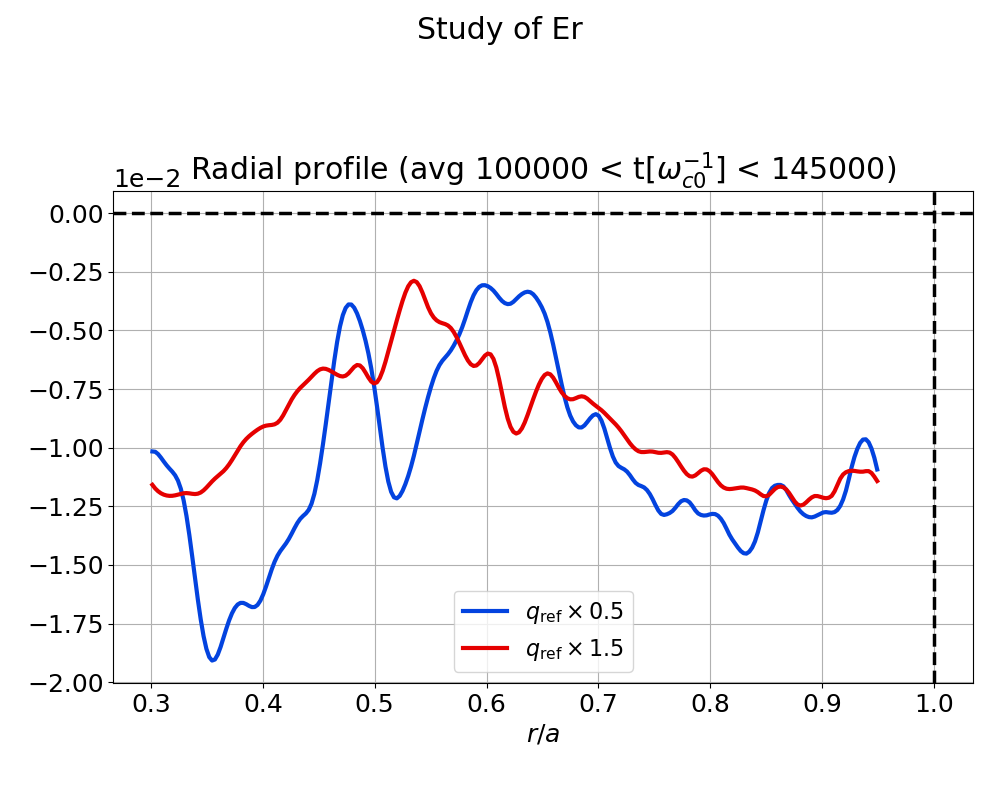

In [62]:
plt.close('all')
clear_output()

fig = plt.figure(figsize=(10,8))

def update_plot(N,param,param2,float_range_time,
                select_sim,dpi_adjust,bool_end_sim):

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    tmin_avg,tmax_avg = float_range_time

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    plt.clf()
    ax_rprof = fig.add_subplot(111)
    if param2:
        ax_rprof2 = ax_rprof.twinx()
        ax_rprof2.grid(False)

    ## Set axes customizations
    if bool_end_sim: ax_rprof.set_title(r'Radial profile (avg last %.0f $[\omega_{c0}^{-1}]$)' % (tmin_avg) )
    else:            ax_rprof.set_title(r'Radial profile (avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f)' % (tmin_avg , tmax_avg) )
    fig.suptitle(r'Study of %s' %param)
    
    i=0
    for iq,q in enumerate(q_ar):

        if bool_end_sim:
            tmax = q['time'][-1]
            itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmax-tmin_avg,tmax])
        else:
            itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin, irhomax     = np.searchsorted(q['rho'],[0.3,0.95])

        p_ma = uniform_filter1d(uniform_filter1d(q[param][itmin_avg:itmax_avg,irhomin:irhomax],size=N,axis=1),size=N,axis=1)

        ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean( p_ma,axis=0),c=q['c'],ls=q['ls'],label=q['title_fancy'],lw=3)

        if param2:
            p_ma2 = uniform_filter1d(uniform_filter1d(q[param2],size=N,axis=1),size=N,axis=1)
            ax_rprof2.plot(q['rho'][irhomin:irhomax], np.mean( p_ma2[itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c2'],label=q['title'])
        
    ## Axes customizations
    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.axhline(y=0,c='k',ls='--')
    ax_rprof.axvline(x=1,c='k',ls='--')
    ax_rprof.legend(fontsize=16)
    #ax_rprof.set_ylim([min(ax_rprof.get_ylim()[0],ax_rprof2.get_ylim()[0]),max(ax_rprof.get_ylim()[1],ax_rprof2.get_ylim()[1])])
    #ax_rprof.set_ylim(-0.025,0)
    ## set y ticks in scientific notation
    ax_rprof.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=512.2e3, step=1000, description='Time range', layout=Layout(width='50%'), continuous_update=False)


interact(update_plot, 
         float_range_time = float_range_time_slider,
         bool_end_sim     = widgets.Checkbox(value=False,description='End of simulation',disabled=False),
         **custom_widgets
        )

## <font color='xkcd:sage'>**Exploration**</font> - Evolution temporelle

In [4]:
plt.close('all')
clear_output()

fig = plt.figure(figsize=(12,6))

def update_plot(N,param,param2,float_range_rho,float_range_time,
                select_sim,dpi_adjust):

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    tmin_avg  ,tmax_avg   = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    color1 = 'xkcd:cerulean'
    color2 = 'xkcd:reddish orange'

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    plt.clf()
    ax_tevol = fig.add_subplot(111)
    if param2:
        ax_tevol2 = ax_tevol.twinx()
        ax_tevol2.grid(False)

    ## Set axes customizations
    ax_tevol.set_title(r'Temporal evolution (avg %.2f < $r/a$ < %.2f)' % (rhomin_avg , rhomax_avg) )
    fig.suptitle(r'Study of %s' %param)
    
    for q in q_ar:

        itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin, irhomax     = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)

        ax_tevol.plot(q['time'][itmin_avg:itmax_avg], np.mean( p_ma[itmin_avg:itmax_avg,irhomin:irhomax],axis=1),c=q['c'],label=q['title'])
        
        if param2:
            p_ma2 = uniform_filter1d(uniform_filter1d(q[param2],size=N,axis=1),size=N,axis=1)
            ax_tevol2.plot(q['time'][itmin_avg:itmax_avg], np.mean( p_ma2[itmin_avg:itmax_avg,irhomin:irhomax],axis=1),c=q['c2'],label=q['title'])
        
    ## Axes customizations
    ax_tevol.set_xlabel(r'$t[\omega_{c0}^{-1}]$')
    ax_tevol.axhline(y=0,c='k',ls='--')
    ax_tevol.legend()
    #ax_tevol.set_ylim([min(ax_tevol.get_ylim()[0],ax_tevol2.get_ylim()[0]),max(ax_tevol.get_ylim()[1],ax_tevol2.get_ylim()[1])])
    if param2:
        ax_tevol2.yaxis.label.set_color(color2)
        ax_tevol2.tick_params(axis='y', colors=color2)
        ## Set sale y limit for both axes
        #ax_tevol2.set_ylim([min(ax_tevol.get_ylim()[0],ax_tevol2.get_ylim()[0]),max(ax_tevol.get_ylim()[1],ax_tevol2.get_ylim()[1])])
    #ax_tevol.plot(q['rho'][10:10+N],np.ones(N)*ax_tevol.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[0e3, 597.6e3], min=0, max=597.6e3, step=1000, description='Time range', layout=Layout(width='50%'), continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.75, 0.85], min=0.1, max=1.3, step=0.01, description='rho range', layout=Layout(width='50%'), continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         **custom_widgets
        )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1, continuous_update=False, description='N', min=1), Text(value='Er', co…

<function __main__.update_plot(N, param, param2, float_range_rho, float_range_time, select_sim, dpi_adjust)>

## <font color='xkcd:sage'>**Exploration**</font> - Video of radial profiles

In [ ]:
plt.close('all')
clear_output

fig = plt.figure(figsize=(12,6))
ax_rprof = fig.add_subplot(111) 

def update_plot(N,dpi_adjust,param,
               select_sim,float_range_rho,
               it_play, time_slider, bool_fixed_y_range,coef_ylim):

    clear_output

    rhomin_avg,rhomax_avg = float_range_rho

    ## Select profiles to plot
    q_ar = [q for q in all_sim if q['title'] in select_sim]

    ## Set title of figure
    fig.suptitle(r'Study of %s' %param)

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom: fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    ax_rprof.clear()

    for q in q_ar:

        ## Find index of rho=0.1 and rho=1.1
        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        ## Compute sliding average
        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)

        ## Plot radial profile
        ax_rprof.set_title(r'Radial profile (at t= %.0f $[\omega_{c0}^{-1}]$)' % (q['time'][it_play]) )
        ax_rprof.plot(q['rho'][irhomin:irhomax], p_ma[it_play,irhomin:irhomax],c=q['c'],label=q['title'])
        ax_rprof.plot(q['rho'][10:10+N],np.ones(N)*ax_rprof.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

    ## Plot reference lines
    ax_rprof.axhline(y=0,c='k',ls='--'); ax_rprof.axvline(x=1,c='k',ls='--')

    ## Set labels and legend
    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.legend()

    ax_rprof.set_xlim([rhomin_avg,rhomax_avg])
    ax_rprof.set_ylim(-5e-6,5e-6)

    ## Fix y range if bool_fixed_y_range is True
    if bool_fixed_y_range:
        ax_rprof.set_ylim(bottom = coef_ylim*np.amin(p_ma), top = coef_ylim*np.amax(p_ma))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    
slider=widgets.IntSlider(value=0,min=0,max=len(all_sim[1]['time']),step=1,description="Time index",layout=Layout(width='50%'))
play  = widgets.Play(value=30,min=0,max=len(all_sim[1]['time']),step=1,interval=400,description="Press play")

coef_ylim_widget = widgets.FloatSlider(value=1,min=0.1,max=1,step=0.05,description="Coef ylim",layout=Layout(width='20%'))
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.1, 1.1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

widgets.jslink((play, 'value'), (slider, 'value'))

interact(update_plot, 
        bool_fixed_y_range = widgets.Checkbox(value=False,description='Fix y range'),
        time_slider = slider,
        it_play = play,
        coef_ylim = coef_ylim_widget,
        float_range_rho = float_range_rho_slider,
        **custom_widgets
        )

## <font color='xkcd:sage'>**Exploration**</font> - Etude d'une quantité dans l'espace réel

In [18]:
clear_output()
plt.close('all')

fig = plt.figure(figsize=(16,10))

def update_plot(N,param,float_range_time,float_range_rho,
               colormap_range,dpi_adjust, symetrical_cmap, select_sim, bool_appearing_lines):
    
    plt.clf()

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    for axes in fig.axes: axes.clear()
    
    fig.suptitle(r'Study of %s' %param)

    Pmap = uniform_filter1d(uniform_filter1d(q_ar[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(3, 2*len(q_ar))
    ax_rprof = fig.add_subplot(gs[2:, 0:len(q_ar)]) 
    ax_tevol = fig.add_subplot(gs[2:, len(q_ar):]) 
    
    for iq,q in enumerate(q_ar):

        print(q['title'] + ' : ' + str(q['time'][0]) + ' to ' + str(q['time'][-1]) + ' [wc0^-1]')

        itmin, itmax      = np.searchsorted(q['time'],[0e3,250e3])
        # itmin = np.argmin( np.abs(q['time']-0e3) )
        # itmax = np.argmin( np.abs(q['time']-250e3) )
        irhomin, irhomax  = np.searchsorted(q['rho'],[0.0,1.1])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:2, 2*iq:2*iq+2]) 

        #ax_map.set_title(q['title_fancy'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][:],p_ma[:,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        if bool_appearing_lines:
            ax_map.axvline(x=rhomin_avg,c='xkcd:purple',ls='-',lw=3); ax_map.axvline(x=rhomax_avg,c='xkcd:purple',ls='-',lw=3)
            ax_map.axhline(y=tmin_avg,c='r',ls='-',lw=3); ax_map.axhline(y=tmax_avg,c='r',ls='-',lw=3)
            
        ax_map.plot(q['rho'][10:10+N],np.ones(N)*ax_map.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualize the sliding average window

        ax_map.set_ylim(0,512.6e3)
        ax_map.set_ylim(0,300e3)
        ax_map.set_xlim(0,1)

        ##Figure 2
        itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

        ax_rprof.set_title(r'Radial profile (avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f)' % (tmin_avg , tmax_avg) )
        ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean( p_ma[itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c'],ls=q['ls'],label=q['title'])
        ax_rprof.set_xlabel(r'$r/a$')
        ax_rprof.axvline(x=rhomin_avg,c='k',ls='--')
        ax_rprof.axvline(x=rhomax_avg,c='k',ls='--')
        ax_rprof.legend()
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        
        ax_tevol.set_title(r'Temporal evolution (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        ax_tevol.plot(q['time'], np.mean(p_ma[:,irhomin_avg:irhomax_avg],axis=1),c=q['c'],ls=q['ls'])
        ax_tevol.set_xlabel(r'Time $[\omega_{c0}^{-1}]$')
    
    for axes in [ax_rprof,ax_tevol]: 
        axes.axhline(y=0,c='k',ls='--')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[200e3, 250e3], min=0, max=512.6e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.8, 0.9], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_range_time     = float_range_time_slider,
         float_range_rho      = float_range_rho_slider,
         colormap_range       = widgets.FloatSlider(min=0.01, max=2, step=0.01,value=0.8, continuous_update=False),
         symetrical_cmap      = widgets.Checkbox(value=False,description='symetrical_cmap'),
         bool_appearing_lines = widgets.Checkbox(value=True,description='Appearing lines'),
         **custom_widgets
        )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1, continuous_update=False, description='N', min=1), Text(value='Er', co…

<function __main__.update_plot(N, param, float_range_time, float_range_rho, colormap_range, dpi_adjust, symetrical_cmap, select_sim, bool_appearing_lines)>

## <font color='xkcd:sage'>**Exploration**</font> - Etude dans l'espace des fréquences <font color='red'>(Bug with last version of FFT)</font>
<font color='red'> /!\ </font> La fréquence théorique des GAMs est calculée comme $f_{theo} = \frac{2}{R_0} \sqrt{ \frac{5}{3} \frac{T}{m}  \left(1 + \frac{1}{2q^2} \right)} \color{red}{\frac{1}{2 \pi}}$ 
En effet, je suspecte que la formule théorique donne la pulsation que tout le monde appelle fréquence par abus de language

<font color='red'> /!\ </font> Les spectres sont calculés avec des moyennes radiales, de cette façon :
- [ ] $\huge TF[\langle s(r,t) \rangle_{r1}^{r2}] $
- [x] $\huge \langle  TF[ s(r,t) ] \rangle_{r1}^{r2}$

PS: les deux sont définis dans le code ci-dessous en tant que "fspectra_1" et "fspectra_2" respectivement.

In [ ]:
plt.close('all')

symetrical_cmap = 0

fig = plt.figure(figsize=(16,10))

def update_plot(N,colormap_range,dpi_adjust,param,float_range_time,float_range_rho,
               select_sim,
               DFTradial_avg1_bool, DFTradial_avg2_bool, show_omega_theo):
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    plt.clf()
    fig.suptitle(r'Study of %s' %param)
    fig.set_dpi(dpi_adjust)

    Pmap = uniform_filter1d(uniform_filter1d(all_sim[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(5, 2*len(q_ar))
    ax_fspectra = fig.add_subplot(gs[3:, 0:len(q_ar)]) 
    ax_fphase = fig.add_subplot(gs[3:, len(q_ar):]) 

    for iq,q in enumerate(q_ar):

        itmin, itmax     = np.searchsorted(q['time'],[0e3,90e3])
        irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.1])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:3, 2*iq:2*iq+2]) 

        ax_map.set_title(q['title'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][itmin:itmax],p_ma[itmin:itmax,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ax_map.axvline(x=rhomin_avg,c='g',ls='-')
        ax_map.axvline(x=rhomax_avg,c='g',ls='-')
        
        ax_map.axhline(y=tmin_avg,c='r',ls='-')
        ax_map.axhline(y=tmax_avg,c='r',ls='-')
        
        ax_map.plot(q['rho'][10:10+N],np.ones(N)*ax_map.get_ylim()[1]/4,c='xkcd:battleship grey',lw=5) #Visualisation de la fenêtre de la moyenne glissante

        ##Figure 2
        itmin_avg, itmax_avg     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        
        #Perform fft
        dt_diag = q['time'][-1]-q['time'][-2]
        fspectra_1 = np.fft.rfft(np.mean(p_ma[itmin_avg:itmax_avg,irhomin_avg:irhomax_avg],axis=1), axis=0) / (itmax_avg-itmin_avg)
        fspectra_2 = np.fft.rfft(p_ma[itmin_avg:itmax_avg,:], axis=0) / (itmin_avg-itmax_avg)
        w = np.fft.rfftfreq(itmax_avg-itmin_avg, d=dt_diag)
        
        
        ax_fspectra.set_title(r'Fourier amplitude (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        if DFTradial_avg1_bool:ax_fspectra.semilogy(w,np.abs(fspectra_1),c=q['c'],label=q['title'],ls='--') #Pour fspectra_1
        if DFTradial_avg2_bool:ax_fspectra.semilogy(w,np.mean(np.abs(fspectra_2[:,irhomin_avg:irhomax_avg]),axis=1),ls='-',c=q['c'],label=q['title']) #Pour fspectra_2
        ax_fspectra.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fspectra.legend(fontsize=14)
        
        #Fréquence GAM théorique
        if show_omega_theo:
            omega_theo = np.mean( np.mean( (2*np.sqrt(q['T'] * (5/3) *(1 + (1/(2*q['q']**2) ) )) /800)[itmin_avg:itmax_avg] ,axis=0)[irhomax_avg-1:irhomax_avg] ) / (2 * np.pi)
            ax_fspectra.axvline(x=omega_theo,c=q['c'],ls='--')
        
        
        ax_fphase.set_title(r'Fourier phase (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        if DFTradial_avg1_bool:ax_fphase.plot(np.sort(w), np.angle(fspectra_1),ls='--',c=q['c'],label=q['title']) #Pour fspectra_1
        if DFTradial_avg2_bool:ax_fphase.plot(np.sort(w), np.mean(np.angle(fspectra_2[:,irhomin_avg:irhomax_avg]),axis=1),ls='-',c=q['c'],label=q['title']) #Pour fspectra_2
        ax_fphase.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fphase.axhline(y=0,ls='--',c='k')
        ax_fphase.legend(fontsize=16)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[50e3, 90e3], min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.84, 0.86], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

#custom_widgets['param'].value = 'Ptransfert'

interact(update_plot, 
         float_range_time=float_range_time_slider,
         float_range_rho=float_range_rho_slider,
         colormap_range=widgets.FloatSlider(min=0.1, max=2, step=0.05,value=0.8, continuous_update=False),
         DFTradial_avg1_bool = widgets.Checkbox(value=False,description='Display fspectra_1'),
         DFTradial_avg2_bool = widgets.Checkbox(value=True,description='Display fspectra_2'),
         show_omega_theo = widgets.Checkbox(value=False,description=r'Display $\omega_{theo}$'),
         **custom_widgets,
        )

## <font color='xkcd:sage'>**Exploration**</font> - Densité spectrale de puissance

La DPS est calculée comme $ PSD(x) = 2 \frac{ |X(\omega)|^2 }{ N } \Delta T $ où $N$ est le nombre d'échantillons temporels (le facteur 2 vient du fait qu'on considère le nombre de points $N_f=N/2$ dans le domaine spectral).

Ce calcul donne exactement le même résultat que la fonction *periodogram* de *scipy.signal* ... sauf pour la fréquence nulle.

In [ ]:
plt.close('all')

fig = plt.figure(figsize=(16,10))

symetrical_cmap = 0
def update_plot(N,colormap_range,dpi_adjust,param,float_range_time,float_range_rho,show_omega_theo,
               select_sim,mode):
    
    tmin_avg,tmax_avg = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig.clf()
    
    fig.suptitle(r'Study of %s' %param)
    fig.set_dpi(dpi_adjust)

    Pmap = uniform_filter1d(uniform_filter1d(q_ar[0][param],size=N,axis=1),size=N,axis=1)
    if symetrical_cmap:
        vmin = colormap_range*min( abs( np.min(Pmap) ), abs( np.max(Pmap) ) ) 
        vmax = -vmin
    else:
        vmin = colormap_range*np.min(Pmap) 
        vmax = colormap_range*np.max(Pmap) 

    gs = gridspec.GridSpec(5, 2*len(q_ar))
    ax_fspectra = fig.add_subplot(gs[3:, 0:len(q_ar)]) 
    ax_rprof = fig.add_subplot(gs[3:, len(q_ar):]) 

    for iq,q in enumerate(q_ar):
        
        irhomin, irhomax = np.searchsorted(q['rho'], [0.2, 1.1])
        itmin, itmax = np.searchsorted(q['time'], [0e3, 303e3])

        print(q['time'][itmin])

        p_ma = uniform_filter1d(uniform_filter1d(q[param],size=N,axis=1),size=N,axis=1)
        
        ## Figure 1
        ax_map = fig.add_subplot(gs[0:3, 2*iq:2*iq+2]) 

        ax_map.set_title(q['title'])
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],q['time'][itmin:itmax],p_ma[itmin:itmax,irhomin:irhomax],vmin=vmin,vmax=vmax)
        fig.colorbar(p,ax=ax_map)
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')

        ax_map.axvline(x=1,c='k',ls='--')
        for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ax_map.axvline(x=rhomin_avg,c='g',ls='-')
        ax_map.axvline(x=rhomax_avg,c='g',ls='-')
        
        ax_map.axhline(y=tmin_avg,c='r',ls='-')
        ax_map.axhline(y=tmax_avg,c='r',ls='-')

        ax_map.set_xlim([0.2,1.1])
        
        if N>1: ax_map.plot(q['rho'][40:40+N],np.ones(N)*ax_map.get_ylim()[1]*3/4,c='xkcd:battleship grey',lw=5) #Visualisation de la fenêtre de la moyenne glissante
        
        ##Figure 2
        itmin_avg, itmax_avg     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        
        #Perform fft
        dt_diag = q['time'][-1]-q['time'][-2]
        fspectra = np.fft.rfft(p_ma[itmin_avg:itmax_avg,:], axis=0) / (itmax_avg-itmin_avg)
        w = np.fft.rfftfreq(itmax_avg-itmin_avg, d=dt_diag)
        
        
        ax_fspectra.set_title(r'Fourier amplitude (avg %.2f < r/a < %.2f)' % (rhomin_avg , rhomax_avg) )
        ax_fspectra.semilogy(w,2*np.mean(np.abs(fspectra[:,irhomin_avg:irhomax_avg])**2 * ((itmax_avg-itmin_avg)*dt_diag),axis=1),c=q['c'],label=q['title'],ls='-',marker='o',markersize=3,mfc=q['c'], mec=q['c'], alpha=0.5)
        ax_fspectra.set_xlabel(r'$\omega [\omega_{c0}]$')
        ax_fspectra.legend(fontsize=14)
        #ax_fspectra.axvline(x=w[mode], ls='--', c='g',lw=1)

        #Fréquence GAM théorique
        if show_omega_theo:
            omega_theo = np.mean( np.mean( (2*np.sqrt(q['T'] * (5/3) *(1 + (1/(2*q['q']**2) ) )) /800)[itmin_avg:itmax_avg] ,axis=0)[irhomax_avg-1:irhomax_avg] ) / (2 * np.pi)
            ax_fspectra.axvline(x=omega_theo,c=q['c'],ls='--')

        irholimmin = (np.abs(q['rho'] - 0.5 )).argmin()
        irholimmax = (np.abs(q['rho'] - 1 )).argmin()
        ax_rprof.set_title(r'Profile of $\omega = %.1e [\omega_{c0}]$ component' % w[mode])
        ax_rprof.semilogy(q['rho'][irholimmin:irholimmax], 
                      2*np.abs(fspectra[mode,irholimmin:irholimmax])**2 * ((itmax_avg-itmin_avg)*dt_diag), c=q['c']
                     )
        
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=303e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider = widgets.FloatRangeSlider(value=[0.84, 0.86], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

#custom_widgets['param'].value = 'Ptransfert'

interact(update_plot, 
         mode             = widgets.IntSlider(min=0, max=50, step=1,value=0, continuous_update=False),
         overlap_factor   = widgets.FloatSlider(min=0, max=1, step=0.05,value=0.8),
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         colormap_range   = widgets.FloatSlider(min=0.1, max=2, step=0.05,value=0.8, continuous_update=False),
         show_omega_theo  = widgets.Checkbox(value=False,description=r'Display $\omega_{theo}$'),
         **custom_widgets
        )

## <font color='xkcd:sage'>**Exploration**</font> - Cross corrélation en temps
ps: un time-lag $\tau$ négatif veut dire que "signal2" précède "signal1" de $\tau$

In [6]:
clear_output()

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def extract_fluctuations(signal2D):
    return signal2D - np.mean(signal2D,axis=0)

def update_plot(N1,N2,float_range_rho,dpi_adjust,float_range_time,
               select_sim, signal1, signal2):
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    tmin_avg,tmax_avg = float_range_time
    
    plt.close('all')
    
    fig = plt.figure(figsize=(8*len(q_ar),16), dpi=dpi_adjust)
    fig.suptitle('Cross correlation between %s and %s' %(signal1,signal2))
    
    gs = gridspec.GridSpec(3,len(q_ar))
    
    ###############################
    #Figure 3 layout - Cross correlation at a given radius
    ###############################
    ax_cc1D = fig.add_subplot(gs[2, :]) 
    ax_cc1D.set_ylim(-1.1,1.1)
    ax_cc1D.axhline(y=0,c='k',ls='--'); ax_cc1D.axhline(y=1,c='gray',ls='--'); ax_cc1D.axhline(y=-1,c='gray',ls='--')
    ax_cc1D.axvline(x=0,c='k',ls='--')
    ax_cc1D.set_xlabel(r'Time lag $[\omega_{c0}^{-1}]$')
    
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'], [0.0, 1.1])
        itmin, itmax     = np.searchsorted(q['time'], [tmin_avg, tmax_avg])

        itlim = itmax-itmin
        itau_range = np.r_[-itlim//3:itlim//3]

        tau_range = itau_range * (q['time'][1]-q['time'][0])

        it_CC_range = np.r_[itlim//3:2*itlim//3]
        Cfg = np.zeros( (irhomax-irhomin, 2*itlim//3 ) )
        
        signal1_ar = uniform_filter1d(uniform_filter1d(q[signal1],size=N1,axis=1),size=N1,axis=1)
        signal2_ar = uniform_filter1d(uniform_filter1d(q[signal2],size=N2,axis=1),size=N2,axis=1)

        f = extract_fluctuations(signal1_ar[itmin:itmax,irhomin:irhomax])
        g = extract_fluctuations(signal2_ar[itmin:itmax,irhomin:irhomax])

        norm = np.sqrt( np.sum(f[it_CC_range,:]**2,axis=0) ) * np.sqrt( np.sum(g[it_CC_range,:]**2,axis=0) )
        for itau in itau_range:
            Cfg[:,itau + itlim//3] = np.sum(f[it_CC_range,:] * g[it_CC_range+itau,:],axis=0)/norm


        rhomin_avg,rhomax_avg = float_range_rho
        irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
        ##############################
        #Figure - 2D cross correlation
        ##############################
        ax_map = fig.add_subplot(gs[0, iq]) 
        ax_map.set_title('Cross correlation over radius')
        p=ax_map.pcolormesh(q['rho'][irhomin:irhomax],tau_range,Cfg.T,vmin=-1,vmax=1)
        ax_map.axhline(y=0,c='k',ls='--')
        cax = inset_axes(ax_map, width="30%", height="5%", loc=1, bbox_to_anchor=(0,0.2,1,1), bbox_transform=ax_map.transAxes) 
        fig.colorbar(p,cax=cax,orientation='horizontal')
        ax_map.axvline(x=rhomin_avg,c='g',lw=4)
        ax_map.axvline(x=rhomax_avg,c='g',lw=4)
        ax_map.set_title(r'%s' % q['title'])
        ax_map.set_xlabel(r'$r/a$')
        ax_map.set_ylabel(r'Time lag')
        ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
        
        ##############################
        #Figure - Time evolution
        ##############################
        color1 = 'xkcd:green'
        color2 = 'xkcd:purple'
        
        itbeg = (np.abs(q['time'] - 0e3 )).argmin()//3*3
        ax_tevol1 = fig.add_subplot(gs[1, iq]) 
        ax_tevol1.set_title('%s - Time evolution avg on $%.2f < r/a < %.2f$' %(q['title'],rhomin_avg,rhomax_avg))
        ax_tevol1.plot(q['time'][itbeg:],np.mean(q[signal1][itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color1,ls='--')
        ax_tevol1.plot(q['time'][itbeg:],np.mean(signal1_ar[itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color1)
        ax_tevol1.yaxis.label.set_color(color1)
        ax_tevol1.tick_params(axis='y', colors=color1)
        ax_tevol1.set_ylabel(signal1)
        
        ax_tevol2 = ax_tevol1.twinx()
        ax_tevol2.plot(q['time'][itbeg:],np.mean(q[signal2][itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color2,ls='--')
        ax_tevol2.plot(q['time'][itbeg:],np.mean(signal2_ar[itbeg:,irhomin_avg:irhomax_avg],axis=1),c=color2)
        ax_tevol2.grid(None)
        ax_tevol2.yaxis.label.set_color(color2)
        ax_tevol2.tick_params(axis='y', colors=color2)
        ax_tevol2.set_ylabel(signal2)
        ax_tevol1.axvline(x=tmin_avg,c='k',ls='--'); ax_tevol1.axvline(x=tmax_avg,c='k',ls='--')
        ax_tevol1.set_xlabel(r'Time $[\omega_{c0}^{-1}]$')
        
        ##############################
        #Figure 3 layout - Cross correlation at a given radius
        ##############################
        ax_cc1D.set_title(r'Cross correlation avg on $%.2f < r/a < %.2f$' %(rhomin_avg,rhomax_avg))
        ax_cc1D.plot(tau_range, np.mean(Cfg[irhomin_avg:irhomax_avg,:],axis=0),c=q['c'],lw=4,label=q['title'])
    
    ax_cc1D.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

float_range_time_slider = widgets.FloatRangeSlider(value=[100e3, 145e3], min=0, max=600e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.8, 0.9], min=0, max=1.2, step=0.01, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         N1=widgets.IntSlider(min=1, max=200, step=1,value=1, continuous_update=False),
         N2=widgets.IntSlider(min=1, max=200, step=1,value=1, continuous_update=False),
         float_range_time=float_range_time_slider,
         float_range_rho=float_range_rho_slider,
         signal1 = widgets.Text(value='drRSpol',placeholder='Type something',description='Select parameter:', continuous_update=False),
         signal2 = widgets.Text(value='Er',placeholder='Type something',description='Select parameter:', continuous_update=False),
         **custom_widgets
        )

interactive(children=(IntSlider(value=1, continuous_update=False, description='N1', max=200, min=1), IntSlider…

<function __main__.update_plot(N1, N2, float_range_rho, dpi_adjust, float_range_time, select_sim, signal1, signal2)>

<a id='en_cours_cons_vorticity'></a>
## <font color='royalblue'>**Résultat**</font> - Conservation de la vorticité généralisée[▲](#sommaire)

Avec l'implémentation actuelle de l'équation de Poisson dans GYSELA (en circulaire), l'équation de conservation de la vorticité intégrée doit être calculée avec $B_0$ et $n(t=0,r)=n_0$.

L'équation vérifiée est alors :
$\partial_t \left[ - \partial_r \left( \frac{m n_0}{B_0} \partial_r \langle \phi \rangle_{FS} + \frac{m}{2eB_0^2} \partial_r \langle P_\perp \rangle_{FS} \right) \right] + e \partial_r \langle \Gamma_{Dr} + \Gamma_{Er} \rangle_{FS} = 0$


interactive(children=(IntSlider(value=97, continuous_update=False, description='dpi_adjust', max=200, min=30),…

<function __main__.update_plot(dpi_adjust, float_time, float_range_rho, select_sim, vorticity_bool, current_bool, density_bool, same_y_range)>

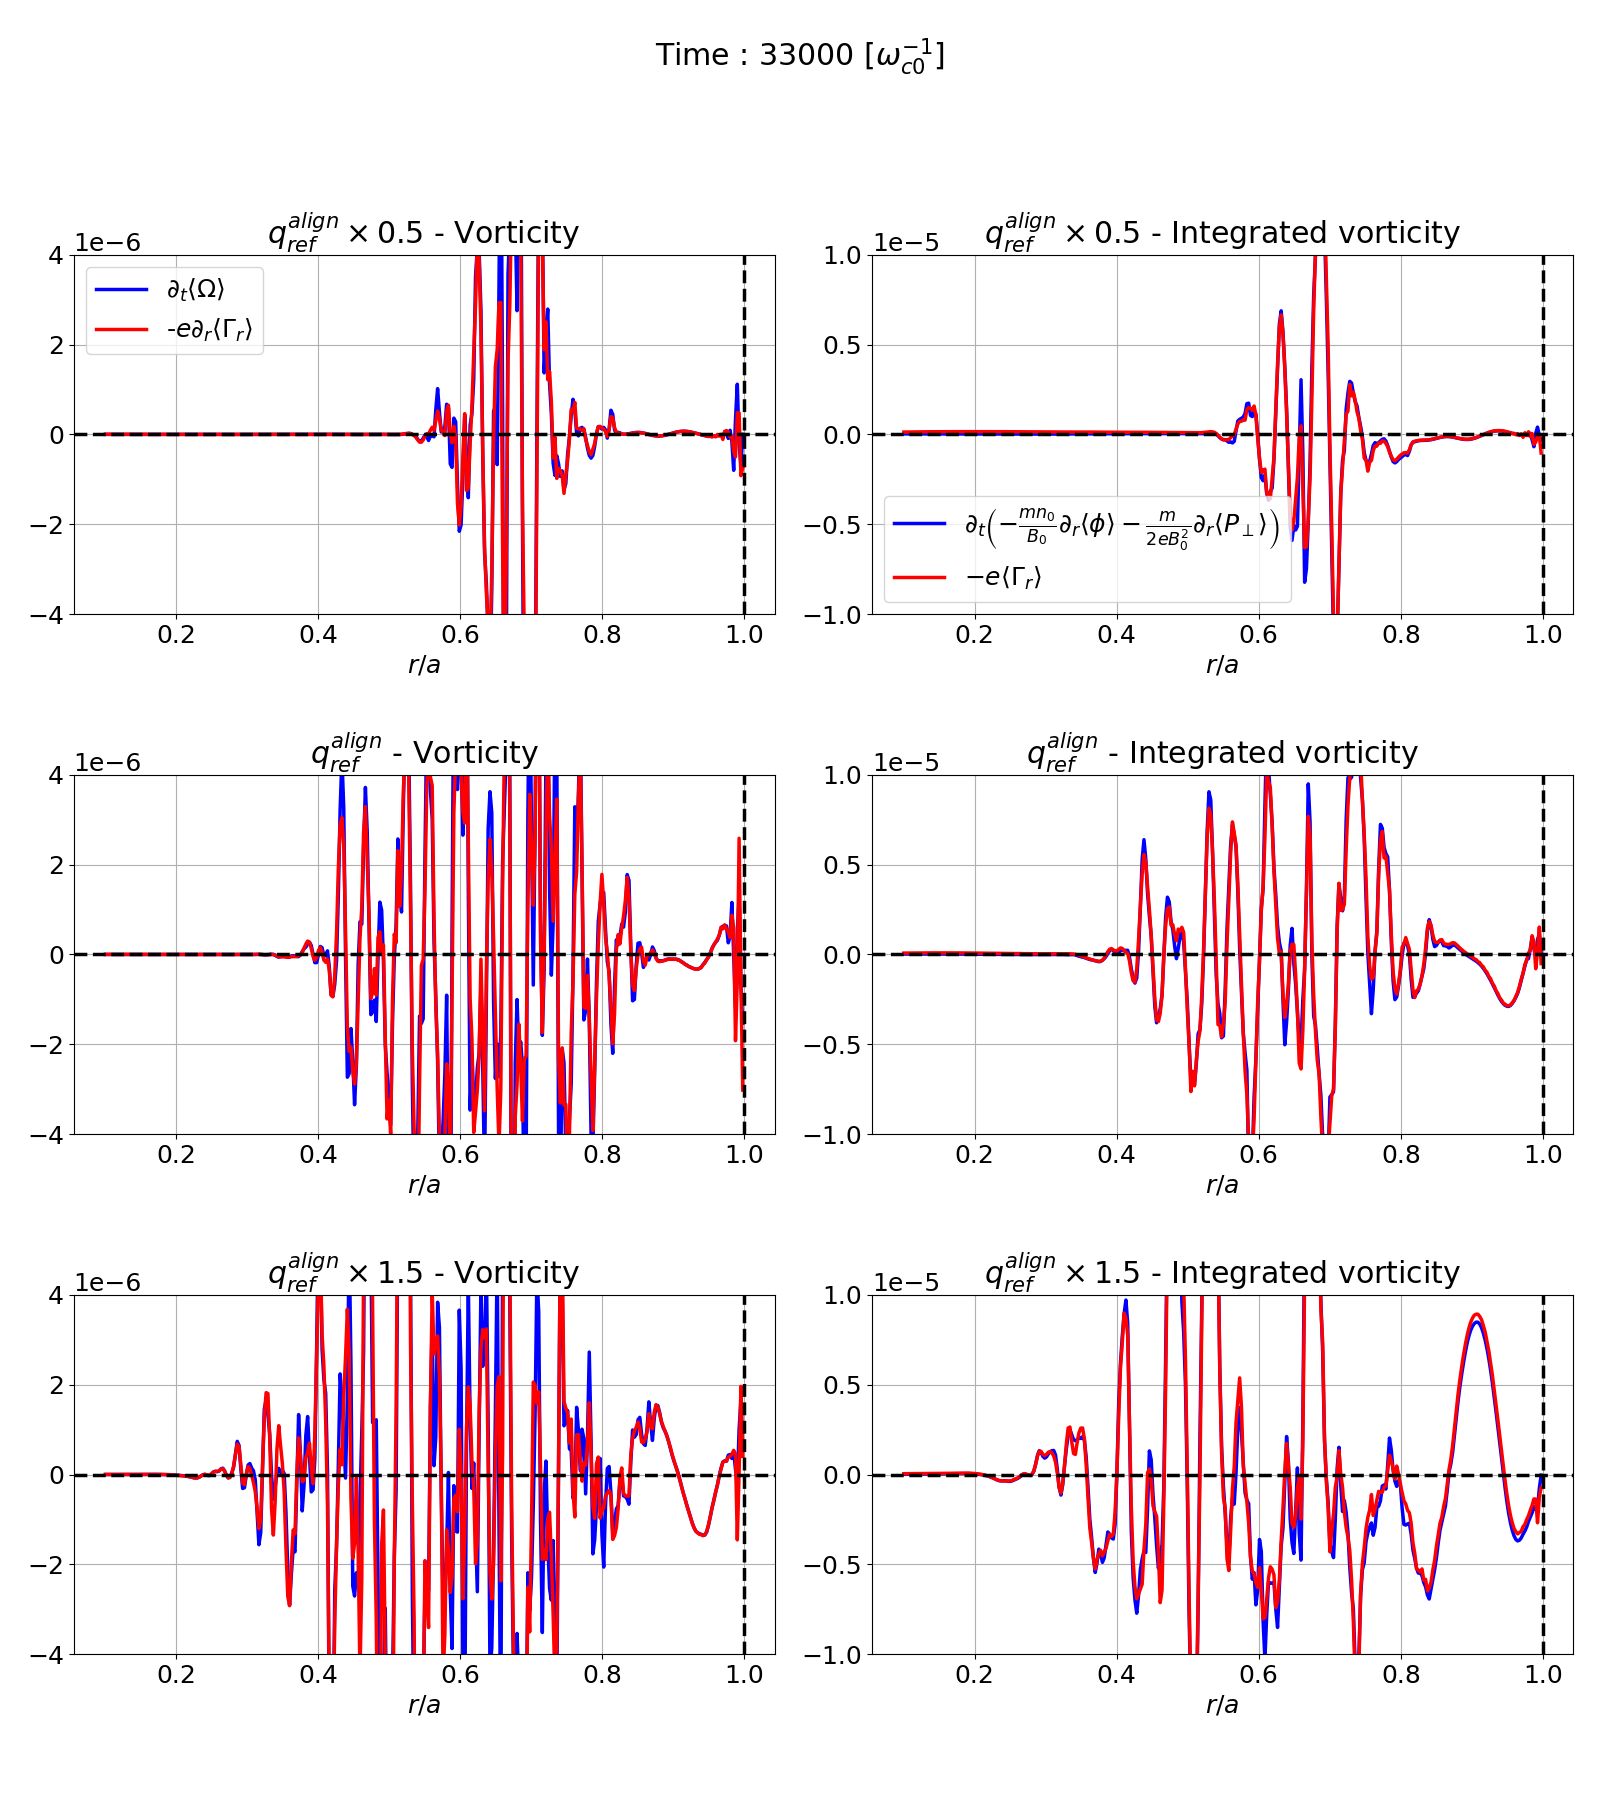

In [7]:
plt.close('all')
clear_output()

fig = plt.figure()

def update_plot(dpi_adjust,float_time,float_range_rho,select_sim,
                vorticity_bool,current_bool,density_bool,
                same_y_range):
    
    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    plt.clf()
    
    ## Set figure size
    fig.set_size_inches(16,6*len(q_ar))

    tscan = float_time
    rhomin,rhomax = float_range_rho

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),2,2*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        if vorticity_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], q['dtvorticity'][itscan,irhomin:irhomax],c='b',label=r'$\partial_t \langle \Omega \rangle$')
        if current_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], -q['drJr'][itscan,irhomin:irhomax],c='r',ls='-',label=r'-$ e \partial_r \langle \Gamma_r \rangle$')
        if density_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], q['dtn'][itscan,irhomin:irhomax],c='purple',label=r'$\partial_t n$')
        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),2,2*iq+2)
        
        int_dndt = np.cumsum(q['dtn'][:,irhomin:irhomax],axis=1)
        print(int_dndt.shape)
                             
        ax_rprof2.set_title(q['title'] + r' - Integrated vorticity')
        if vorticity_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], q['dtP'][itscan,irhomin:irhomax],c='b',label=r'$\partial_t \left(-\frac{m n_0}{B_0} \partial_r \langle\phi\rangle - \frac{m}{2eB_0^2} \partial_r \langle P_\perp \rangle\right)$')
        if current_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], -q['Jr'][itscan,irhomin:irhomax],c='r',label=r'$-e \langle \Gamma_r \rangle $')
        if density_bool:ax_rprof2.plot(q['rho'][irhomin:irhomax], int_dndt[itscan,:],c='purple',label=r'$\int_{r_0}^r \partial_t n$')
        if same_y_range:ax_rprof2.set_ylim(-1e-5,1e-5)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
            if iq==0:axes.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider      = widgets.FloatSlider(value=33e3, min=0, max=303e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         vorticity_bool = widgets.Checkbox(value=True,description='Display vorticity term'),
         current_bool   = widgets.Checkbox(value=True,description='Display current term'),
         density_bool   = widgets.Checkbox(value=False,description='Display density term'),
         same_y_range   = widgets.Checkbox(value=True,description='Same y range'),
         **custom_widgets
        )

## <font color='green'>**Papier**</font> - Conservation de la vorticité généralisée

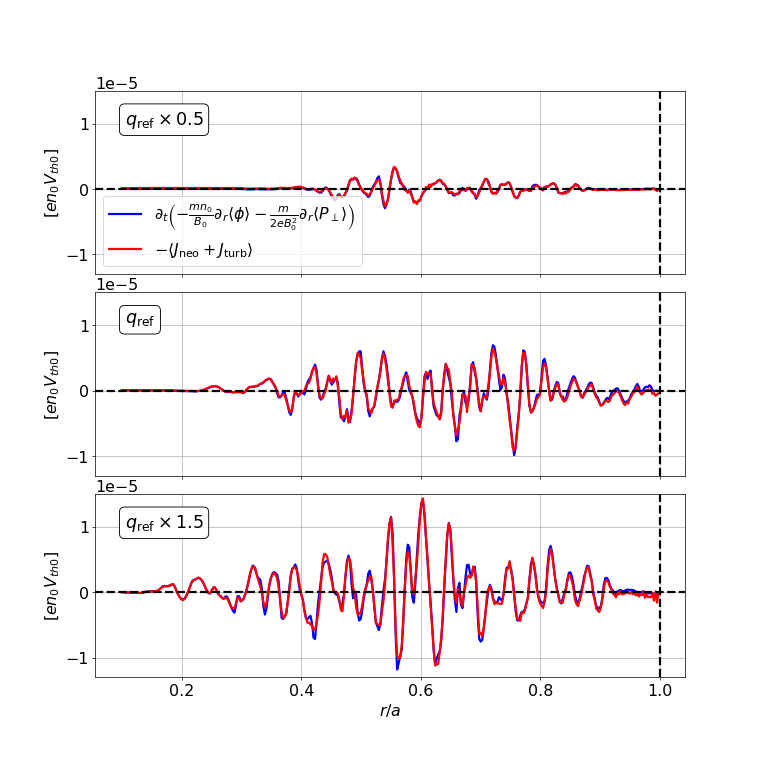

In [61]:
plt.close('all')
clear_output()

fig = plt.figure()
    
q_ar = all_sim

## Set figure size
fig.set_size_inches(12,4*len(q_ar))

tscan = 100e3
rhomin,rhomax = 0.1, 1

#fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

## Set dpi of figure
fig.set_dpi(dpi_custom)

for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
    
    itscan = np.searchsorted(q['time'],tscan)

    ax_rprof2 = fig.add_subplot(len(q_ar),1,iq+1)

    P=-q['As'] * (- q['ns0'] * q['Er'] + 0.5 * q['Zs']**(-1) * q['drPperp'])
    evol_Er = - q['ns0'] * q['dtEr']
    evol_Pperp = 0.5 * q['Zs']**(-1) * q['dtdrPperp']
                            
    ax_rprof2.plot(q['rho'][irhomin:irhomax], q['dtP'][itscan,irhomin:irhomax],c='b',label=r'$\partial_t \left(-\frac{m n_0}{B_0} \partial_r \langle\phi\rangle - \frac{m}{2eB_0^2} \partial_r \langle P_\perp \rangle\right)$')
    # ax_rprof2.plot(q['rho'][irhomin:irhomax], evol_Pperp[itscan,irhomin:irhomax],c='g',ls='--',label=r'$ - \frac{m}{2eB_0^2} \partial_r \langle P_\perp \rangle$')
    ax_rprof2.plot(q['rho'][irhomin:irhomax], -q['Jr'][itscan,irhomin:irhomax],c='r',label=r'$-\langle J_{\rm neo} + J_{\rm turb} \rangle $')
    ax_rprof2.set_ylim(-1.3e-5,1.5e-5)

    for axes in [ax_rprof2]:
        axes.set_xlabel(r'$r/a$')
        axes.axhline(y=0,c='k',ls='--')
        axes.axvline(x=1,c='k',ls='--')
        axes.set_ylabel(r'$[e n_0 V_{th0}]$')
        if iq==0:axes.legend(loc='lower left')

    if iq != len(q_ar)-1:
        ax_rprof2.set_xticklabels([])
        ax_rprof2.set_xlabel('')

    ## add text
    ax_rprof2.text(0.05, 0.9, q['title_fancy'], transform=ax_rprof2.transAxes, fontsize=20, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=1))


    plt.subplots_adjust(wspace=0, hspace=0.1)

#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_integrated_vorticity.pdf', format='pdf', bbox_inches='tight')

<a id='en_cours_tf_phi'></a>
## <font color='coral'>**Travail en cours**</font> - Spectre 2D de $\phi(\theta,\varphi)$[▲](#sommaire)

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)

q05_spectra = hdf5_to_dict("data/q05_growthrate_2Dspectra.hdf5")
q15_spectra = hdf5_to_dict("data/q15_growthrate_2Dspectra.hdf5")

print(q05_spectra.keys())

def Fourier2D(F0, y0, x0):

    """ Personal FFT2D function"""

    nx0 = len(x0)
    nx  = 2 * int(nx0 / 2)
    hnx = int(nx / 2)
    ny0 = len(y0)
    ny  = 2 * int(ny0 / 2)
    hny = int(ny / 2)

    x = x0[0:nx]
    y = y0[0:ny]
    F = F0[0:ny, 0:nx]

    Lx   = x[nx - 1] - x[0]
    dx   = x[1] - x[0]
    dkx  = 2. * np.pi / (Lx + dx)
    kx   = np.zeros(nx)
    temp = -dkx * np.r_[1:hnx + 1]
    kx[0:hnx]  = temp[::-1]
    kx[hnx:nx] = dkx * np.r_[0:hnx]

    Ly   = y[ny - 1] - y[0]
    dy   = y[1] - y[0]
    dky  = 2. * np.pi / (Ly + dy)
    ky   = np.zeros(ny)
    temp = -dky * np.r_[1:hny + 1]
    ky[0:hny]  = temp[::-1]
    ky[hny:ny] = dky * np.r_[0:hny]

    TFF = np.zeros((ny, nx), dtype=complex)
    AA  = np.zeros((ny, nx), dtype=complex)
    var = np.conjugate(np.fft.fft2(np.conjugate(F))) / float((nx * ny))

    AA[:, 0:hnx]   = var[:, hnx:nx]
    AA[:, hnx:nx]  = var[:, 0:hnx]
    TFF[0:hny, :]  = AA[hny:ny, :]
    TFF[hny:ny, :] = AA[0:hny, :]

    return TFF, kx, ky

for iq,q in enumerate([q05_spectra,q15_spectra]):
    print('qrpeak = %.2f' % q['q_rpeak'])
    phi2D = q['Phithphi']**2

    Nphi = len(q['phig'])-1
    Ntheta = len(q['thetag'])-1

    tevol_TFPhi2D = np.zeros((len(q['time']),Nphi,Ntheta))

    for it in range(len(q['time'])):
        tevol_TFPhi2D[it,:,:] = np.abs(Fourier2D(phi2D[it,0:Nphi+1,0:Ntheta+1],q['phig'],q['thetag'])[0])

    m2d,n2d = Fourier2D(phi2D[-1,0:Nphi+1,0:Ntheta+1],q['phig'],q['thetag'])[1:]
    dm2d = (m2d[1]-m2d[0])//2 ; m2d = m2d-dm2d
    dn2d = (n2d[1]-n2d[0])//2 ; n2d = n2d-dn2d

    ## Calculate the linear growth rate between tinit and tend
    tinit = 15e3
    tend  = 19e3

    itinit = np.argmin(np.abs(q['time']-tinit))
    itend  = np.argmin(np.abs(q['time']-tend))

    Gammalin2D = np.log(tevol_TFPhi2D[itend,:,:]/tevol_TFPhi2D[itinit,:,:])/(tend-tinit)

    C = 140
    n_ex = np.argmin(np.abs(n2d-dn2d-C))
    m_ex = np.argmin(np.abs(m2d-dm2d+C*q['q_rpeak']))

    fig = plt.figure(figsize=(18,6))

    ## Plot the 2D spectrum
    ax1 = fig.add_subplot(131)
    p1 = ax1.pcolormesh(m2d,n2d,np.log10(tevol_TFPhi2D[-30,:,:]),vmin=-10,vmax=0)    
    fig.colorbar(p1)
    ax1.set_xlabel(r'$m$')
    ax1.set_ylabel(r'$n$')
    ax1.set_title(r'$\log_{10}(|\tilde{\phi}|^2)$')
    ax1.plot(m2d,-m2d/q['q_rpeak'],c='k',ls='--')
    ## Add the point n_ex,m_ex to the plot
    ax1.plot(m2d[m_ex],n2d[n_ex],'r+')

    ## Plot the time evolution of the spectrum at n_ex,m_ex
    ax2 = fig.add_subplot(132)
    ax2.plot(q['time'],np.log10(tevol_TFPhi2D[:,n_ex,m_ex]))
    ax2.axvline(tinit,c='k',ls='--')
    ax2.axvline(tend,c='k',ls='--')

    ## Plot the growth rate
    ax3 = fig.add_subplot(133)
    p3 = ax3.pcolormesh(m2d,n2d,Gammalin2D[:,:],vmin=0) 
    fig.colorbar(p3)

    fig.tight_layout()


<a id='en_cours_spectre_taux_croissance'></a>
## <font color='coral'>**Travail en cours**</font> - Spectre du taux de croissance [▲](#sommaire)

In [ ]:
q05_spectra = hdf5_to_dict("data/q05_growthrate_2Dspectra.hdf5")
print(q05_spectra.keys())

nsize = np.abs(q05_spectra['n'][-1] - q05_spectra['n'][0])
dn    = np.abs(q05_spectra['n'][1] - q05_spectra['n'][0])
dm    = np.abs(q05_spectra['m'][1] - q05_spectra['m'][0])
m     = q05_spectra['m']
q     = q05_spectra['q_rpeak']

## Plot the growth rate spectra in 2D
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.set_title("Growth rate spectra in 2D")
ax1.set_xlabel(r"$m$")
ax1.set_ylabel(r"$n$")

p = ax1.pcolormesh(q05_spectra['m'],q05_spectra['n'],q05_spectra['growth_rate_spectra'])
fig.colorbar(p)

tol = 80

## Plot lines of constant n=-m/q and range to cover
n = (-m/q + nsize/2)%nsize - nsize/2 - dn
ax1.plot(m, n, ls='--', c='r')
ax1.plot(m, ((-m-tol)/q + nsize/2)%nsize - nsize/2 - dn, ls='--', c='r')
ax1.plot(m, ((-m+tol)/q + nsize/2)%nsize - nsize/2 - dn, ls='--', c='r')

## Plot the growth rate spectra in 1D taking all mode on the n=-m/q line
growth_rate1D_n = np.zeros(len(q05_spectra['m']))
growth_rate1D_m = np.zeros(len(q05_spectra['m']))
for im in range(len(q05_spectra['m'])):
    growth_rate1D_n[im] = np.mean(q05_spectra['growth_rate_spectra'][
                    np.where((q05_spectra['n'] >= n[im]-tol) & (q05_spectra['n'] <= n[im]+tol)), im]
                    )
    growth_rate1D_m[im] = np.mean(q05_spectra['growth_rate_spectra'][np.argmin(np.abs(q05_spectra['n'] - n[im])),
                    np.where((q05_spectra['m'] >= m[im]-tol) & (q05_spectra['m'] <= m[im]+tol))]
                    )

## Plot the growth rate spectra in 1D
ktheta_rhoi = (m / q05_spectra['rpeak']) * np.sqrt(q05_spectra['T_rpeak']/2)

im_lim = np.argmin(np.abs(q05_spectra['m'] - 240)) 

ax2 = fig.add_subplot(122)
ax2.set_title("Growth rate spectra in 1D")
ax2.set_xlabel(r"$k_\theta \rho_i$")
ax2.set_ylabel(r"$\gamma$")
ax2.plot(ktheta_rhoi,growth_rate1D_n, label=r'Sum over $n$ range (vertical)')
ax2.plot(ktheta_rhoi,growth_rate1D_m, label=r'Sum over $m$ range (horizontal)')
ax2.plot(ktheta_rhoi,(growth_rate1D_n+growth_rate1D_m)/2, label=r'Mean of the two')
ax2.axvline(x=ktheta_rhoi[im_lim], ls='--', c='k')
ax2.set_xlim(left=0)
ax2.legend()
fig.tight_layout()

<a id='en_cours_spectre_taux_croissance'></a>
## <font color='coral'>**Travail en cours**</font> - Depliement du spectre [▲](#sommaire)

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)

#-------------------------------------------------
# Personal inverse FFT2D function
#-------------------------------------------------
def iFourier2D(TFF, ky, kx, axes=(0, 1), pad=(False, False), real=True):
    """ Personal FFT2D inverse function"""
    kx = np.asarray(kx)
    assert kx.ndim == 1
    ky = np.asarray(ky)
    assert ky.ndim == 1

    nx  = len(kx)
    hnx = int(nx / 2)
    dkx = abs(kx[1] - kx[0])
    x   = np.r_[0:nx] * 2. * np.pi / (nx * dkx)

    ny  = len(ky)
    hny = int(ny / 2)
    dky = abs(ky[1] - ky[0])
    y   = np.linspace(0, 2 * np.pi / dky, ny, endpoint=False)

    TFF = np.fft.ifftshift(TFF, axes=axes)
    F = np.fft.ifft2(nx * ny * np.conjugate(TFF), axes=axes)
    if real:
        F = F.real
    else:
        F = F.conj()
    #end if

    # Add the redundant point on the transformation axis
    if any(pad):
        pad_width = np.zeros((F.ndim, 2))
        pad_width[axes, 1] = pad
        print(pad_width)
        F = np.pad(F, pad_width, 'wrap')
    #end if

    return F, x, y
#end def iFourier2D
#--------------------------------------------------

q= hdf5_to_dict("data/q05_growthrate_2Dspectra.hdf5")

print('qrpeak = %.2f' % q['q_rpeak'])
phi2D = q['Phithphi']**2

Nphi = len(q['phig'])-1
Ntheta = len(q['thetag'])-1

tevol_TFPhi2D = np.zeros((len(q['time']),Nphi,Ntheta))

for it in range(len(q['time'])):
    tevol_TFPhi2D[it,:,:] = np.abs(Fourier2D(phi2D[it,0:Nphi+1,0:Ntheta+1],q['phig'],q['thetag'])[0])

m2d,n2d = Fourier2D(phi2D[-1,0:Nphi+1,0:Ntheta+1],q['phig'],q['thetag'])[1:]
dm2d = (m2d[1]-m2d[0])//2 ; m2d = m2d
dn2d = (n2d[1]-n2d[0])//2 ; n2d = n2d

fig = plt.figure(figsize=(24,12))

## Plot the 2D spectrum
ax1 = fig.add_subplot(121)
p1 = ax1.pcolormesh(m2d,n2d,np.log10(tevol_TFPhi2D[-30,:,:]),vmin=-10,vmax=0)    
fig.colorbar(p1)
ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$n$')
ax1.set_title(r'$\log_{10}(|\tilde{\phi}|^2)$')

ax1.plot(m2d,-m2d/q['q_rpeak'],c='k',ls='--')

ax1.plot(m2d-m2d[len(m2d)//4],-m2d/q['q_rpeak'],c='k',ls='--')

ax1.plot(m2d+m2d[len(m2d)//4],-m2d/q['q_rpeak'],c='k',ls='--')

ax2 = fig.add_subplot(122)

TF_test = tevol_TFPhi2D[-30,:,:]

ncoord = np.arange(0,3*Nphi-1)
mcoord = np.arange(0,Ntheta-1)


## Define an array which stacks 3 times vertically the 2D spectrum
TF_test = np.vstack((TF_test,TF_test,TF_test))

for i_n in ncoord:
    for i_m in mcoord:
        if i_n > 2*Nphi - (1/(8*q['q_rpeak']))*(i_m-Ntheta//2):
            TF_test[i_n,i_m] = 0
        if i_n < Nphi - (1/(8*q['q_rpeak']))*(i_m-Ntheta//2):
            TF_test[i_n,i_m] = 0

p2 = ax2.pcolormesh(np.log10(TF_test),vmin=-10,vmax=0)
ax2.plot(Ntheta//2, 3*Nphi//2, marker='x', c='r',markersize=40)

m0 = 45
ax2.plot(Ntheta//2 + m0, 3*Nphi//2 - (1/8)*m0/q['q_rpeak'], marker='x', c='r',markersize=40)

ax2.plot(mcoord,  2*Nphi - (1/(8*q['q_rpeak']))*(mcoord-Ntheta//2) , c='k', ls='--')

fig.tight_layout()

## Proof of concept: function that take real 2D signal and return filtered 2D signal
def repliement_spectre(Phi2D,qrp):
    Nphi   = len(Phi2D[:,0])-1
    Ntheta = len(Phi2D[0,:])-1
    Lphi   = 2*np.pi / 8 #
    coef   = 2*np.pi / Lphi # A changer pour une fonction plus generale
    TFPhi2D_or,m2d,n2d = Fourier2D(Phi2D,q['phig'],q['thetag'])
    TFPhi2D            = np.vstack((TFPhi2D_or,TFPhi2D_or,TFPhi2D_or)) # On stack verticalement 2 fois le même spectre pour avoir un motif complet
    for i_n in range(3*Nphi): # Puis on enleve les modes en trop
        for i_m in range(Ntheta):
            if i_n > 2*Nphi - (1/(coef*qrp))*(i_m-Ntheta//2):
                TFPhi2D[i_n,i_m] = 0
            if i_n < Nphi - (1/(coef*qrp))*(i_m-Ntheta//2):
                TFPhi2D[i_n,i_m] = 0
    #Inverse Fourier transform of complex 2D signal
    new_n2d = np.arange(-1.5*Nphi,1.5*Nphi)*coef # Nouvelle grille pour les modes toroidaux
    Phi2D_filtered, varphi, theta = iFourier2D(TFPhi2D, m2d, new_n2d)
    return Phi2D_filtered, varphi, theta



mode = 8
fig = plt.figure(figsize=(8,8))
varphi_ar = np.linspace(0,2*np.pi/8,Nphi+1)
plt.plot(varphi_ar,phi2D[-30,:,mode])
Phi_filtered, varphi, theta = repliement_spectre(phi2D[-30,:,:], q['q_rpeak'])
plt.plot(varphi,Phi_filtered[:,mode])

print(phi2D[-30,:,:].shape)
print(Phi_filtered.shape)

## <font color='coral'>**Travail en cours**</font> - Depliement du spectre sur Phi3D

In [ ]:
def repliement_spectre_3D(Phi3D,q1D):
    Nphi   = len(Phi3D[:,0,0])-1
    Ntheta = len(Phi3D[0,:,0])-1
    Nr     = len(Phi3D[0,0,:])-1
    Lphi   = 2*np.pi / 8 # Cas particulier du 8e de tore
    coef   = 2*np.pi / Lphi # A changer pour une fonction plus generale

    Phi3D_filtered = np.zeros_like(Phi3D)

    for ir in range(Nr):
        TFPhi2D_or,m2d,n2d = Fourier2D(Phi3D[:,:,ir],q['phig'],q['thetag'])
        TFPhi2D            = np.vstack((TFPhi2D_or,TFPhi2D_or,TFPhi2D_or)) # On stack verticalement 2 fois le même spectre pour avoir un motif complet
        for i_n in range(3*Nphi): # Puis on enleve les modes en trop
            for i_m in range(Ntheta):
                if i_n > 2*Nphi - (1/(coef*q1D[ir]))*(i_m-Ntheta//2): # Condition probablement + facilement generalisable avec m2d et n2d
                    TFPhi2D[i_n,i_m] = 0
                if i_n < Nphi - (1/(coef*q1D[ir]))*(i_m-Ntheta//2):
                    TFPhi2D[i_n,i_m] = 0
        #Inverse Fourier transform of complex 2D signal
        new_n2d = np.arange(-1.5*Nphi,1.5*Nphi)*coef # Nouvelle grille pour les modes toroidaux
        Phi2D_filtered, varphi, theta = iFourier2D(TFPhi2D, m2d, new_n2d)
        Phi3D_filtered[:,:,ir] = Phi2D_filtered
    return Phi3D_filtered ## Même dimension que Phi3D sauf pour la dimension toroidale qui est 3*Nphi

<a id='en_cours_cons_vorticity'></a>
## <font color='coral'>**Travail en cours**</font> - Contribution des termes à $\partial_t E_r$[▲](#sommaire)

## <font color='coral'>**Travail en cours**</font> - Tenseur diamagnétique dans les simulations alignées

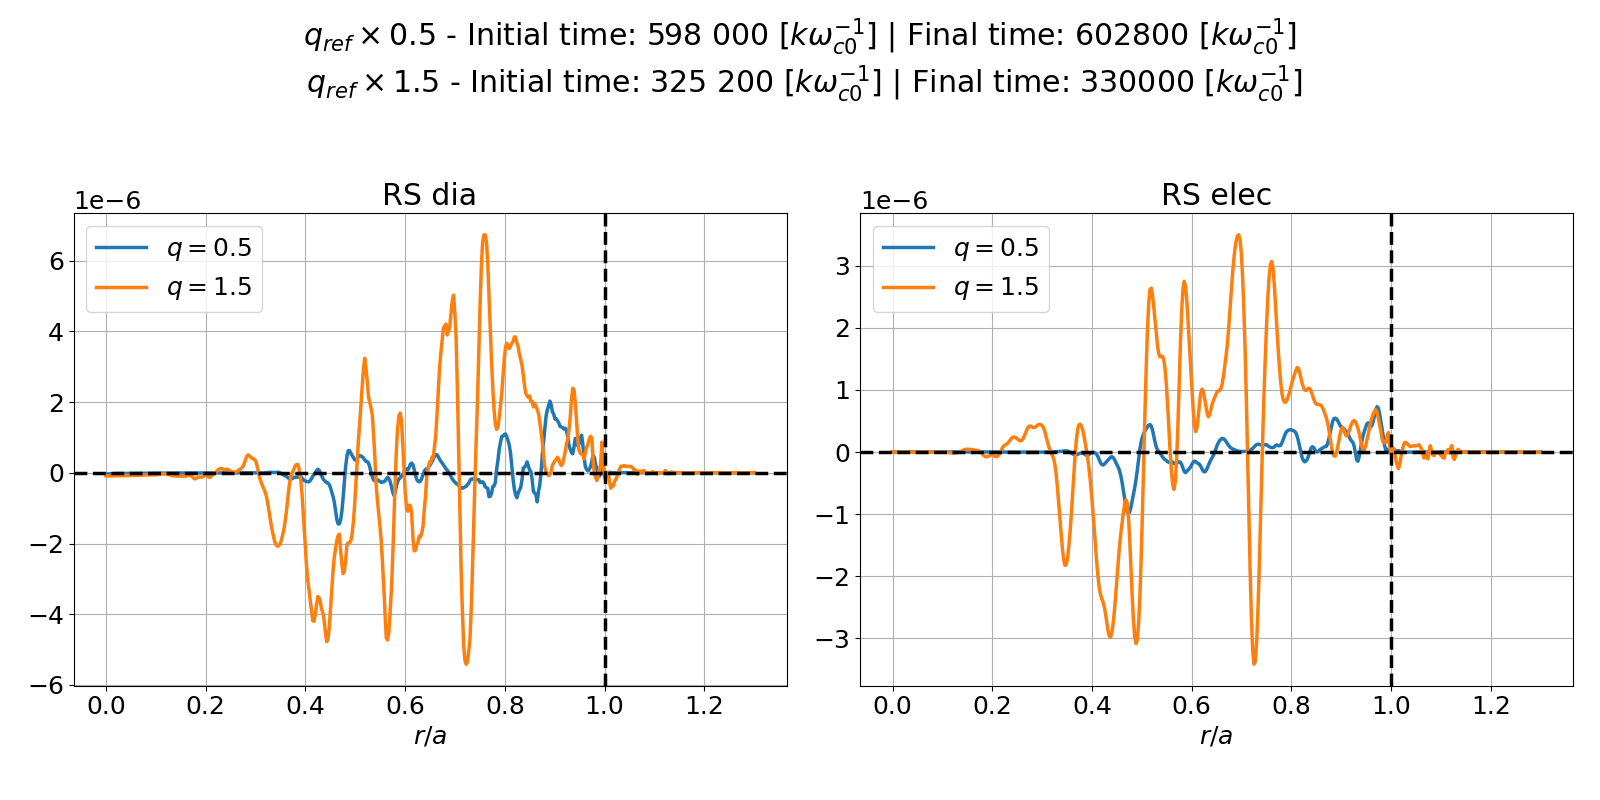

In [26]:
qprof_05_RSdia   = np.load('data/q05_aligned_RSdia_FSavg.npy')
qprof_05_RSelec  = np.load('data/q05_aligned_RSelec_FSavg.npy')

qprof_15_RSdia  = np.load('data/q15_aligned_RSdia_FSavg.npy')
qprof_15_RSelec = np.load('data/q15_aligned_RSelec_FSavg.npy')

if 0:
    qprof_05_alignedGC7 = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 0.5$', 'xkcd:blue', 'xkcd:green', '-')
    qprof_15_alignedGC7 = load_qprof_dict('data/TS45511_q15_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 1.5$', 'xkcd:red', 'xkcd:bordeaux', '-')

rho = np.linspace(0,1.3,len(qprof_05_RSdia[0,:]))

fig = plt.figure(figsize=(16,8))
fig.suptitle(r'$q_{ref} \times 0.5$ - Initial time: 598 000 $[k\omega_{c0}^{-1}]$ | Final time: 602800 $[k\omega_{c0}^{-1}]$' +  
             '\n ' + 
             r'$q_{ref} \times 1.5$ - Initial time: 325 200 $[k\omega_{c0}^{-1}]$ | Final time: 330000 $[k\omega_{c0}^{-1}]$')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rho, np.mean(qprof_05_RSdia,axis=0), label=r'$q=0.5$')
ax1.plot(rho, np.mean(qprof_15_RSdia,axis=0), label=r'$q=1.5$')

ax2.plot(rho, np.mean(qprof_05_RSelec,axis=0), label=r'$q=0.5$')
ax2.plot(rho, np.mean(qprof_15_RSelec,axis=0), label=r'$q=1.5$')
if 0:
    tmax = qprof_05_alignedGC7['time'][-1]; tmin = tmax-4000
    itmax = np.searchsorted(qprof_05_alignedGC7['time'],tmax); itmin = np.searchsorted(qprof_05_alignedGC7['time'],tmin)
    ax2.plot(rho, np.mean(qprof_05_alignedGC7['RSpol_vE'][itmin:itmax,:],axis=0), label=r'$q=0.5$ - native')

    tmax = qprof_15_alignedGC7['time'][-1]; tmin = tmax-4000
    itmax = np.searchsorted(qprof_05_alignedGC7['time'],tmax); itmin = np.searchsorted(qprof_05_alignedGC7['time'],tmin)
    ax2.plot(rho, np.mean(qprof_15_alignedGC7['RSpol_vE'][itmin:itmax,:],axis=0), label=r'$q=1.5$ - native')

ax1.set_title(r'RS dia')
ax2.set_title(r'RS elec')


for axes in fig.axes:
    axes.set_xlabel(r'$r/a$')
    axes.axhline(y=0,c='k',ls='--')
    axes.axvline(x=1,c='k',ls='--')
    axes.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## <font color='coral'>**Travail en cours**</font> - Comparer $J_r$ aux prédictions

In [41]:
clear_output()

q_ar = all_sim

for q in q_ar:
    fig = plt.figure(figsize=(20,8))
    ax1  = fig.add_subplot(121)

    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,0.9])
    rho = q['rho'][irhomin:irhomax]

    itmin, itmax = np.searchsorted(q['time'],[200e3,300e3])

    Jturb = ( q['Jr_vE'] - q['Jr_vEn0'] )[-1,irhomin:irhomax]

    if 'RSdia' in q.keys():
        divPiturb =  q['drRSpol'][-1,irhomin:irhomax] + q['drRSdia'][-1,irhomin:irhomax]
    else:
        divPiturb =  q['drRSpol'][-1,irhomin:irhomax] * 3


    ax1.plot(rho,Jturb,label=r'$J_{Er} - J_{Er, n=0}$')
    ax1.plot(rho,-divPiturb,label=r'$\nabla \cdot (\Pi_{E \times B} + \Pi_{dia})$')
    #ax1.plot(q['rho'],-q['drRSdia'][-1,:],label=r'$\nabla \cdot \Pi_{dia}$')

    ax2 = fig.add_subplot(122)
    Jneo = 1*q['Jr_vD'][itmin:itmax,irhomin:irhomax] + 1*q['Jr_vEn0'][itmin:itmax,irhomin:irhomax]
    nutheta = q['nuneo_Gianakon'][itmin:itmax,irhomin:irhomax]
    Vneo  = -( (1 - q['Kneo_Kim_all']) * q['drT'] + (q['T']/q['n']) * q['drn'] + (q['eps']/q['q'])*q['VT'])[itmin:itmax,irhomin:irhomax]
    contrib_neo = -5*nutheta * (q['m_Er'][itmin:itmax,irhomin:irhomax] - 1.17*Vneo) #+ 6e-7
    # contrib_neo = -3*nutheta * (q['m_Er'][itmin:itmax,irhomin:irhomax] - Vneo)
    #contrib_neo_test = -nutheta * (q['m_Er'][itmin:itmax,irhomin:irhomax])

    ax2.plot(rho,np.mean(Jneo,axis=0),label=r'$J_{Dr} + J_{Er, n=0}$')
    ax2.plot(rho,np.mean(contrib_neo,axis=0),label=r'$- \nu_\theta (V_E - V_{neo})$')
    #ax2.plot(rho,np.mean(contrib_neo_test,axis=0),label=r'$- \nu_\theta (V_E - V_{neo})$ - test')
    #ax2.plot(rho,-1.5e-5*q['m_Er'][-1,irhomin:irhomax],label=r'test')

    for axes in fig.axes:
        axes.set_xlabel(r'$r/a$')
        axes.axhline(y=0,c='k',ls='--')
        axes.axvline(x=1,c='k',ls='--')
        axes.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='coral'>**Travail en cours**</font> - Estimer $\nu_{neo}$ comme $-J_{neo} / (V_E - V_{neo})$

In [7]:
clear_output()

q_ar = all_sim

for q in q_ar:
    fig = plt.figure(figsize=(20,8))
    ax1  = fig.add_subplot(111)

    print(q['time'][-1])
    itdiag = np.searchsorted(q['time'],50e3)

    Jneo             = 1*q['Jr_vD'][itdiag,:] + 1*q['Jr_vEn0'][itdiag,:]
    nuneo_gianakon = q['nuneo_Gianakon'][itdiag,:]
    Vneo             = -( (1 - q['Kneo_Kim_all']) * q['drT'] + (q['T']/q['n']) * q['drn'] + (q['eps']/q['q'])*q['VT'])[itdiag,:]

    nuneo_estimated = - Jneo / (q['m_Er'][itdiag,:] - Vneo)

    ax1.plot(q['rho'],nuneo_estimated,label=r'nuneo_estimated')
    ax1.plot(q['rho'],nuneo_gianakon,label=r'nuneo_gianakon')

    for axes in fig.axes:
        axes.set_xlabel(r'$r/a$')
        axes.axhline(y=0,c='k',ls='--')
        axes.axvline(x=1,c='k',ls='--')
        axes.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

602600.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

299000.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

329800.0


## <font color='royalblue'>**Résultat**</font> - Profil radial du **facteur de sécurité** $q$

In [4]:
plt.rc('font',size=24)
#q_ar = [qprof_05,qprof_1,qprof_15]
q_ar = all_sim

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
#ax1.set_title('Safety factor')
for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[0.2,1.0])

    irho = (np.abs(q['rho'] - 0.95 )).argmin()
    ax1.plot(q['rho'][irhomin:irhomax], q['q'][irhomin:irhomax], label=q['title_fancy']+r', $q_{95} = %.1f$' % q['q'][irho],c=q['c'],lw=4,marker=q['marker'],markevery=me)
ax1.legend()
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$q$')
ax1.axvline(x=1,ls='--',c='k'); ax1.axhline(y=0,ls='--',c='k')
ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

ax1.axhline(y=1,c='g',ls='-.',lw=3)
ax1.text(x=0.8, y=0.9, s=r'$q=1$', verticalalignment='top',c='g')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.set_size_inches(8, 8)
fig.savefig('Figures/rprof_q_profiles.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='royalblue'>**Résultat**</font> - Profil radial du **tenseur de Reynolds $\Pi_{r \theta}$** (moyenné en temps **et** coarse-grained)

In [15]:
# q_ar = [qprof_05,qprof_1,qprof_15]
q_ar = all_sim
# q_ar = [all_sim[0],all_sim[-1]]


fig = plt.figure(figsize=(8,6))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

N=60
def u1d(X):return uniform_filter1d(uniform_filter1d(X,size=N),size=N)

def g1d(X):
    return gaussian_filter1d(X,sigma=N)

for iq,q in enumerate(q_ar):
    
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
    # itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])
    itmin, itmax     = np.searchsorted(q['time'],[200.0e3,300.0e3])
    
    ax1.plot(q['rho'][irhomin:irhomax], np.mean(q['RSpol'][itmin:itmax,irhomin:irhomax],axis=0),ls='--',c=q['c'],lw=2)
    ax1.plot(q['rho'][irhomin:irhomax], u1d(np.mean(q['RSpol'][itmin:itmax,irhomin:irhomax],axis=0)),c=q['c'],label=q['title_fancy'],lw=4)

    ax1.axhline(y=0,ls='--',c='k')

ax1.set_ylabel(r'$\Pi_{r \theta}$ $[V_{T0}^2]$')

ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.legend(loc='lower right')
ax1.set_xlabel(r'$r/a$')

plt.text(x=0.01, y=0.85, s='Plain: coarse-grained \ndashed: time average only', transform=ax1.transAxes)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_RSpol_scanq.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='royalblue'>**Résultat**</font> - Profil radial de l'intensité turbulente: début saturation

In [ ]:
# q_ar = [qprof_05,qprof_1,qprof_15]
q_ar = all_sim

fig = plt.figure(figsize=(8,8))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

N=1
def u1d(X):return uniform_filter1d(uniform_filter1d(X,size=N),size=N)

def g1d(X):
    return gaussian_filter1d(X,sigma=N)

for iq,q in enumerate(q_ar):
    
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])

    itmin, itmax     = np.searchsorted(q['time'],[50.0e3,85.0e3])
    
    ax1.plot(q['rho'][irhomin:irhomax], u1d(np.mean(np.sqrt(q['Isq_Te'])[itmin:itmax,irhomin:irhomax],axis=0)),c=q['c'],label=q['title_fancy'],lw=4)

ax1.axhline(y=0,ls='--',c='k')
ax1.axvline(x=1,ls='--',c='k')

ax1.set_ylabel(r'$I_{\rm turb}$')

ax1.ticklabel_format(axis='y',scilimits=(-5,5),useMathText=True)

ax1.legend()
ax1.set_xlabel(r'$r/a$')

ax1.set_ylim(top=0.04)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_RSpol_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Profil radial du **coarse-grained $- \nabla \cdot \Pi_{r_\theta}$ avec une fenêtre radiale de $\sim 40 \rho_i$**

In [9]:
#q_ar = [qprof_05,qprof_1,qprof_15]

q_ar = all_sim
# q_ar = [all_sim[0],all_sim[-1]]

param_ar = ['drRSpol_vE']

N=60
Ng=30

for ip,p in enumerate(param_ar):
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
        itmin, itmax     = np.searchsorted(q['time'],[200.0e3,300.0e3])
        
        p_ma = uniform_filter1d(uniform_filter1d(np.mean(q[p][itmin:itmax,irhomin:irhomax],axis=0),size=N),size=N)
        p_ga = gaussian_filter1d(np.mean(q[p][itmin:itmax,:],axis=0),sigma=Ng)[irhomin:irhomax]
        
        ax1.plot(q['rho'][irhomin:irhomax], -p_ma, label=q['title_fancy'],lw=3,c=q['c'], ls='-')
        ax1.axhline(y=0,c='k',ls='--')
        ax1.axvline(x=1,c='k',ls='--')
        
        
    ax1.legend()
    ax1.set_xlabel(r'$r/a$')
    ax1.set_ylabel(r'$-\langle \nabla \cdot \Pi_{r \theta} \rangle_{CG}$')
    #ax1.set_xlim(left=0.67,right=1.0)


    fig.tight_layout()
    
    fig.savefig('Figures/rprof_divPiCG_scanq.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='red'>**(old)**</font> <font color='royalblue'>**Résultat**</font> - Profil en $q$ du **coarse-grained $- \nabla \cdot \Pi_{r_\theta}$**

In [ ]:
# q_ar = [qprof_05,qprof_1,qprof_15]
q_ar = all_sim

param_ar = ['drRSpol_vE']

N=60
Ng=30

for ip,p in enumerate(param_ar):
    fig = plt.figure(figsize=(8,6))
    #fig.suptitle(p)
    ax1 = fig.add_subplot(111)
    for iq,q in enumerate(q_ar):

        irhomin, irhomax = np.searchsorted(q['rho'],[0.79,0.81])
        itmin, itmax     = np.searchsorted(q['time'],[50.0e3,80.0e3])
        
        p_ma = uniform_filter1d(uniform_filter1d(np.mean(q[p][itmin:itmax,:],axis=0),size=N),size=N)
        p_ga = gaussian_filter1d(np.mean(q[p][itmin:itmax,:],axis=0),sigma=Ng)[irhomin:irhomax]
        
        ax1.plot(q['q'][irhomin:irhomax], -p_ma[irhomin:irhomax], lw=3,c=q['c'], marker='s',ls='', label=q['title'])
        
        #ax1.plot(q['q'][irhomin:irhomax], 0.3e-7*(-1+q['q'][irhomin:irhomax])**(1/3), c=q['c'])
        
        ax1.axhline(y=0,c='k',ls='--')
        
#     ax1.plot(q['rho'][40:40+Ng],np.ones(Ng)*-0.02,c='k')
#     ax1.plot(q['rho'][100:100+N],np.ones(N)*-0.02,c='k')
        
    
    ax1.set_xlabel(r'$q$')
    ax1.set_xlim(0,5)
    ax1.set_ylabel(r'$-\langle \nabla \cdot \Pi_{r \theta} \rangle_{CG}$ in $%.2f < r/a < %.2f$' %(q['rho'][irhomin], q['rho'][irhomax]) )
    
    qrange = np.linspace(0,5,100)
    ax1.plot(qrange, 0.45e-7*(-1+qrange)**(1/3), c='g', label=r'$C (-1+q)^{1/3}$')
    
    ax1.legend()
    
    fig.savefig('Figures/qprof_divPi_08.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Profil radial de $V_E$

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)
plt.rc('font',size=25)

bool_turb = True
bool_NC = False

q_ar = []

if bool_turb:
    qprof_05_alignedGC7 = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 0.5$', 'xkcd:blue', 'xkcd:green'   , '-', title_fancy=r'$q_{ref} \times 0.5$')
    qprof_15_alignedGC7 = load_qprof_dict('data/TS45511_q15_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 1.5$', 'xkcd:red' , 'xkcd:bordeaux', '-', title_fancy=r'$q_{ref} \times 1.5$')
    q_ar.extend([qprof_05_alignedGC7,qprof_15_alignedGC7])
    trange_avg = 150e3

if bool_NC:
    qprof_05_n0     = load_qprof_dict('data/TS45511_q05_n0.hdf5'    , r'$q_{ref} \times 0.5$ - $n=0$' , 'xkcd:blue', 'xkcd:green'   , '-', title_fancy=r'$q_{ref} \times 0.5$ - Neoclassic')
    qprof_15_n0     = load_qprof_dict('data/TS45511_q15_n0.hdf5'    , r'$q_{ref} \times 1.5$ - $n=0$' , 'xkcd:red' , 'xkcd:bordeaux', '-', title_fancy=r'$q_{ref} \times 1.5$ - Neoclassic')

    if 1:
        qprof_05_n0['ls'] = '--' 
        qprof_15_n0['ls'] = '--' 

    q_ar.extend([qprof_05_n0,qprof_15_n0])
    trange_avg = 25e3


fig = plt.figure(figsize=(10,8))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)
for iq,q in enumerate(q_ar):

    irhomin, irhomax = np.searchsorted(q['rho'],[0.6,1.0])

    tmax = q['time'][-1]; tmin=tmax-trange_avg
    itmin, itmax     = np.searchsorted(q['time'],[tmin,tmax])
    
    ax1.plot(q['rho'][irhomin:irhomax], np.mean( q['Er'][itmin:itmax,irhomin:irhomax],axis=0),ls=q['ls'],c=q['c'],lw=5,label=q['title_fancy'])
    #ax1.plot(q['rho'][irhomin:irhomax], np.mean( q[p][itmin:itmax,irhomin:irhomax],axis=0) /q['q'][irhomin:irhomax],ls='--',c=q['c'],label=q['title'])
    
    ax1.axhline(y=0,ls='--',c='k')
    
ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)
    
ax1.legend()
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$V_E$')
ax1.set_ylim(-1.7e-2,0.1e-2)

ax1.axvline(x=1,ls='--',c='k')

ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if bool_turb:
    fig.savefig('Figures/rprof_edge_VE_turb.pdf', format='pdf', bbox_inches='tight')
    fig.savefig('Figures/Figures_Laure/rprof_edge_VE_turb.png', format='png', bbox_inches='tight')
if bool_NC:
    fig.savefig('Figures/rprof_edge_VE_NC.pdf', format='pdf', bbox_inches='tight')
    fig.savefig('Figures/Figures_Laure/rprof_edge_VE_NC.png', format='png', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Evolution de $V_E$

In [ ]:
plt.close('all')
clear_output()

fig = plt.figure(figsize=(10,8))

def update_plot(N,float_range_rho,float_range_time,
                select_sim,dpi_adjust):

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    tmin_avg  ,tmax_avg   = float_range_time
    rhomin_avg,rhomax_avg = float_range_rho
    
    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    plt.clf()
    ax_tevol = fig.add_subplot(111)

    ## Set axes customizations

    fig.suptitle(r'Study of %s' %'Er')
    
    for q in q_ar:

        itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])
        irhomin, irhomax     = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

        ax_tevol.plot(q['time'][itmin_avg:itmax_avg], np.mean( q['Er'][itmin_avg:itmax_avg,irhomin:irhomax],axis=1),c=q['c'],label=q['title_fancy'])

    ## Axes customizations
    ax_tevol.set_xlabel(r'$t[\omega_{c0}^{-1}]$')
    ax_tevol.axhline(y=0,c='k',ls='--')
    ax_tevol.legend()
    ax_tevol.set_ylim(-0.016,-0.009)

    ax_tevol.ticklabel_format(axis='x',scilimits=(-1,1),useMathText=True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_range_time_slider = widgets.FloatRangeSlider(value=[0e3, 597.6e3], min=0, max=597.6e3, step=1000, description='Time range', layout=Layout(width='50%'), continuous_update=False)
float_range_rho_slider  = widgets.FloatRangeSlider(value=[0.75, 0.85], min=0.1, max=1.3, step=0.01, description='rho range', layout=Layout(width='50%'), continuous_update=False)

interact(update_plot, 
         float_range_time = float_range_time_slider,
         float_range_rho  = float_range_rho_slider,
         **custom_widgets
        )

## <font color='royalblue'>**Résultat**</font> - Profil radial de $\nu^\star$ <font color='red'>(Figure Laure)</font>

In [ ]:
plt.rcParams['axes.formatter.limits'] = (-5,6)
plt.rc('font',size=25)


q_ar = []

qprof_05_alignedGC7 = load_qprof_dict('data/TS45511_q05_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 0.5$', 'xkcd:blue', 'xkcd:green'   , '-', title_fancy=r'$q_{ref} \times 0.5$')
qprof_15_alignedGC7 = load_qprof_dict('data/TS45511_q15_aligned_GC7.hdf5', r'$q_{ref}^{align} \times 1.5$', 'xkcd:red' , 'xkcd:bordeaux', '-', title_fancy=r'$q_{ref} \times 1.5$')
q_ar.extend([qprof_05_alignedGC7,qprof_15_alignedGC7])

# qprof_05_n0_rip_ns033_newfilter= load_qprof_dict('data/q05_ripple_NC_ns033_newfilter.hdf5', r'$q_{ref}^{NC} \times 0.5$ - Ripple TS - $\nu_\star = 0.33$ - newfilter', 'r'     , 'lime'     , '-', title_fancy= r'$q_{ref} \times 0.5$')
# qprof_15_n0_rip_ns1_newfilter  = load_qprof_dict('data/q15_ripple_NC_ns1_newfilter.hdf5' , r'$q_{ref}^{NC} \times 1.5$ - Ripple TS - $\nu_\star = 1$ - newfilter', 'b'     , 'orangered', '-', title_fancy= r'$q_{ref} \times 1.5$')

#q_ar.extend([qprof_05_n0_rip_ns033_newfilter,qprof_15_n0_rip_ns1_newfilter])

fig = plt.figure(figsize=(10,8))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)
for iq,q in enumerate(q_ar):

    irhomin, irhomax = np.searchsorted(q['rho'],[0.6,1.0])

    
    ax1.plot(q['rho'][irhomin:irhomax], q['nustar'][-1,irhomin:irhomax],ls=q['ls'],c=q['c'],lw=5,label=q['title_fancy'])
    
    ax1.axhline(y=0,ls='--',c='k')
    
ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$\nu^\star$')

ax1.axvline(x=1,ls='--',c='k')
ax1.legend(loc='upper left')

ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/Figures_Laure/rprof_nustar_turb.png', format='png', bbox_inches='tight')


## <font color='red'>**(old)**</font>  <font color='royalblue'>**Résultat**</font> - Profil radial de la friction néoclassique $\nu_\theta$ empirique tiré de *Gianakon PoP 2002, p12, Eq(C16)*

In [ ]:
q_ar = [qprof_05,qprof_1,qprof_15]

fig = plt.figure(figsize=(7,7))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

N=60
def u1d(X):return uniform_filter1d(uniform_filter1d(X,size=N),size=N)
def g1d(X):return gaussian_filter1d(X,sigma=N)

for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
    itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

    #Calcul de la friction NC poloidale (cf Gianakon 2002)
    nutheta = (0.452 * np.sqrt(2*q['eps']) * q['nu_i'])/( (1+1.03*q['nustar']**(1/2) +0.31 * q['nustar']) * (1 + 0.66 * q['nustar'] * q['eps']**(3/2))) * (q['q']/q['eps'])**2

    ax1.plot(q['rho'][irhomin:irhomax], np.mean(nutheta[itmin:itmax,irhomin:irhomax],axis=0),ls=q['ls'],c=q['c'],label=q['title'])

    ax1.axhline(y=0,ls='--',c='k')

ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.legend()
ax1.set_xlabel(r'$r/a$')
ax1.set_ylabel(r'$\nu_\theta$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#fig.savefig('Figures/rprof_Pionq_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='green'>**Papier**</font> - Profil radial de **l'intensité turbulente $\mathcal{I}$**

In [10]:
clear_output()

plt.rcParams['axes.formatter.limits'] = (-5,6)
plt.rc('font',size=25)
#q_ar = [qprof_05,qprof_1,qprof_15]

q_ar = all_sim
#q_ar = [all_sim[0],all_sim[-1]]

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

for iq,q in enumerate(q_ar):
    
    irhomin, irhomax = np.searchsorted(q['rho'],[0.4,1.0])
    #itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

    #ax1.plot(q['rho'][irhomin:irhomax], np.sqrt(np.mean( (q['Isq'])[itmin:itmax,irhomin:irhomax],axis=0)),ls=q['ls'],c=q['c'],lw=4,label=q['title'],marker=q['marker'],markevery=me)
    tmin = 200.0e3; tmax = 300.0e3
    itmin, itmax     = np.searchsorted(q['time'],[tmin,tmax])
    ax1.plot(q['rho'][irhomin:irhomax], np.sqrt(np.mean( (q['Isq_Te'])[itmin:itmax,irhomin:irhomax],axis=0)),ls=q['ls'],c=q['c'],lw=5,label=q['title_fancy'])

    

    ax1.axhline(y=0,ls='--',c='k')

    ## Paramètre pour figure Laure
    ax1.set_ylabel(r'$\mathcal{I}$')
    ax1.set_ylim(0,0.04)

## Plot y ticks in percents
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

## Divide the number of y ticks by 2
ax1.locator_params(axis='y', nbins=5)


## Add a text mentionning the time average range
ax1.text(0.2,0.05,r'time avg %.0f < t[$10^3 \omega_{c0}^{-1}$] < %.0f' % (tmin/1e3,tmax/1e3),transform=ax1.transAxes,fontsize=25)

ax1.set_ylabel(r'$\mathcal{I}$')

ax1.legend(loc='upper left',fontsize=25)
ax1.set_xlabel(r'$r/a$')
ax1.set_xlim(left=q['rho'][irhomin],right=q['rho'][irhomax])

ax1.axvline(x=1,ls='--',c='k')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_turb_intens_scanq.pdf', format='pdf', bbox_inches='tight')
fig.savefig('Figures/Figures_Laure/rprof_turb_intens_scanq.png', format='png', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

E:\Temp\ipykernel_6168\3888098644.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


## <font color='royalblue'>**Résultat**</font> - Profil radial de la **fréquence de collision ionique $\nu_i$**

In [ ]:
clear_output()

plt.rcParams['axes.formatter.limits'] = (-5,6)
q_ar = all_sim

title_ar = [r'$\mathcal{I}$']

fig = plt.figure(figsize=(8,6))
#fig.suptitle(p)
ax1 = fig.add_subplot(111)

tmin_avg , tmax_avg = 100.0e3, 145.0e3
tmin_avg , tmax_avg = 0.0e3, 1.0e3

for iq,q in enumerate(q_ar):
    irhomin, irhomax = np.searchsorted(q['rho'],[0.1,1.0])
    itmin, itmax     = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

    ax1.plot(q['rho'][irhomin:irhomax], np.mean( (q['nu_i'])[itmin:itmax,irhomin:irhomax],axis=0),ls=q['ls'],c=q['c'],label=q['title_fancy'],lw=4)

    ax1.axhline(y=0,ls='--',c='k')

ax1.set_ylabel(r'$\nu_i$ $[\omega_{c0}]$')
#ax1.ticklabel_format(axis='y',scilimits=(-1,2),useMathText=True)

ax1.legend()
ax1.set_xlabel(r'$r/a$')

ax1.axvline(x=1,ls='--',c='k')

#ax1.text(0.1, 0.5, r'avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f' % (tmin_avg , tmax_avg), transform=ax1.transAxes, fontsize=14,verticalalignment='top',
#             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig('Figures/rprof_nu_i.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Validation de la simplification sur la **puissance $\mathcal{P} = \langle - \nabla \cdot \Pi_{r\theta} \rangle V_E$**
Dans la littérature, il est souvent fait l'approximation $\int_0^{r_0} \langle - \nabla \cdot \Pi_{r\theta} \rangle V_E \approx \int_0^{r_0} -\langle \Pi_{r\theta} \rangle \partial_r V_E$.
On s'attend à ce que ce soit vrai pour un $r_0$ suffisement grand.
Dans nos simulations, il faut $r_0 \sim 40 \rho_i$ pour que ça marche.

In [ ]:
clear_output()
q_ar = all_sim

for iq,q in enumerate(q_ar):
    #q['Ptransfert'] = -q['dRSpoldr'] * (-q['Er'])
    q['Ptransfert_approx'] = q['RSpol'] * (-q['drEr'])
    q['Ptransfert_res'] = np.gradient(-q['RSpol'] * (-q['Er']), q['rg'], axis=1) 

param_ar = ['Ptransfert', 'Ptransfert_approx']
label_ar = [r'$\nabla \cdot \Pi_{r\theta} \times V_{E\theta}$', r'$\Pi_{r\theta} \times \partial_r V_{E\theta}$']
    
colors_ar = ['xkcd:blue','xkcd:red','xkcd:purple','xkcd:green']
colors_ar2 = ['xkcd:blue green','xkcd:dark orange','xkcd:bright pink','xkcd:apple green']
    
def update_plot(N,dpi_adjust):
    plt.close('all')

    fig = plt.figure(figsize=(6*len(q_ar),6), dpi=dpi_adjust)
    size_window = N * 250 * 1.3 / len(q_ar[0]['rg']) 
    fig.suptitle(r'Approximative window size for avg : %.1f $\rho_i$' % size_window )
    for iq,q in enumerate(q_ar):
        
        irhomin, irhomax = np.searchsorted(q['rho'],[0.0,1.0])
        itmin, itmax     = np.searchsorted(q['time'],[100.0e3,145.0e3])

        ax1 = fig.add_subplot(1,len(q_ar),iq+1)
        ax1.set_title(q['title'])
        for ip,p in enumerate(param_ar):
            ## Plot raw
            ax1.plot(q['rho'][irhomin:irhomax], np.mean(q[p][itmin:itmax,irhomin:irhomax],axis=0), c=colors_ar[ip], lw=1.5, ls='--')

            ## Plot coarse-grained
            ax1.plot(q['rho'][irhomin:irhomax], uniform_filter1d(uniform_filter1d(np.mean(q[p][itmin:itmax,irhomin:irhomax],axis=0),size=N),size=N), label=label_ar[ip],c=colors_ar[ip],lw=3, ls='-')

        ax1.axhline(y=0,c='k',ls='--')
        ax1.legend()
        ax1.set_xlabel(r'$r/a$')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    ax1.plot(q['rho'][10:10+N],np.ones(N)*ax1.get_ylim()[1]/2,c='xkcd:battleship grey',lw=5)

interact(update_plot, **custom_widgets)

## <font color='royalblue'>**Résultat**</font> - Conservation de la vorticité généralisée - <font color='red'>(Figure Xavier)</font>

interactive(children=(IntSlider(value=97, continuous_update=False, description='dpi_adjust', max=200, min=30),…

<function __main__.update_plot(dpi_adjust, float_time, float_range_rho, vorticity_bool, current_bool, density_bool)>

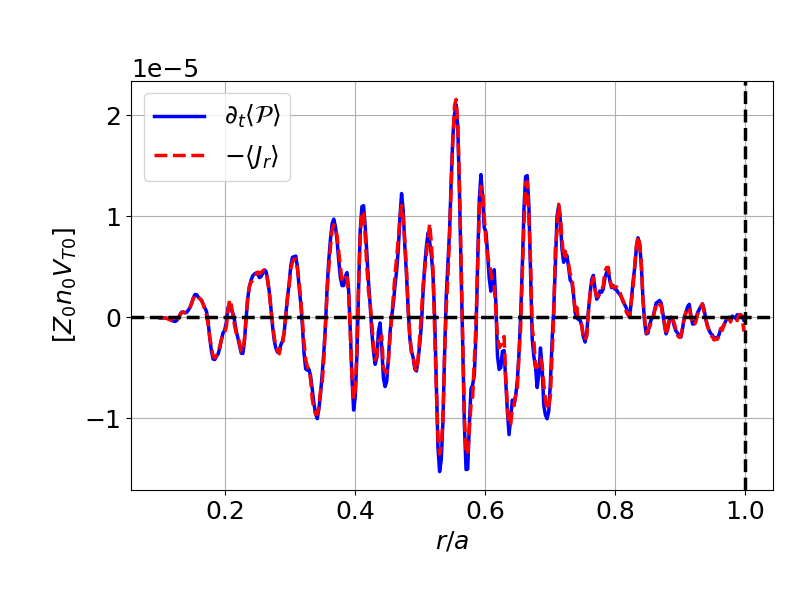

In [6]:
## Load data
qprof_15_alignedGC7  = hdf5_to_dict('data/TS45511_q15_aligned_GC7.hdf5') ; qprof_15_alignedGC7['title'] = r'$q_{ref}^{align} \times 1.5$' ; qprof_15_alignedGC7['c']='xkcd:red'   ; qprof_15_alignedGC7['c2']='xkcd:bordeaux' ; qprof_15_alignedGC7['ls']='-'

plt.close('all')

fig = plt.figure()

def update_plot(dpi_adjust,float_time,float_range_rho,
                vorticity_bool,current_bool,density_bool):
    
    q = qprof_15_alignedGC7
    
    plt.clf()
    
    ## Set figure size
    fig.set_size_inches(8,6)

    tscan = float_time
    rhomin,rhomax = float_range_rho

    #fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
    itscan = np.searchsorted(q['time'],tscan)

    ax_rprof = fig.add_subplot(111)
    
    int_dndt = np.cumsum(q['dtn'][:,irhomin:irhomax],axis=1)
    print(int_dndt.shape)
                            
    #ax_rprof.set_title(q['title'] + r' - Integrated vorticity')
    if vorticity_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], q['dtP'][itscan,irhomin:irhomax],c='b',label=r'$\partial_t \langle \mathcal{P} \rangle$')
    if current_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], -q['Jr'][itscan,irhomin:irhomax],c='r',ls='--',label=r'$- \langle J_r \rangle $')
    if density_bool:ax_rprof.plot(q['rho'][irhomin:irhomax], int_dndt[itscan,:],c='purple',label=r'$\int_{r_0}^r \partial_t n$')

    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.set_ylabel(r'[$Z_0 n_0 V_{T0}}$]')
    ax_rprof.axhline(y=0,c='k',ls='--')
    ax_rprof.axvline(x=1,c='k',ls='--')
    ax_rprof.legend()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider      = widgets.FloatSlider(value=80e3, min=0, max=303e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Normalized radius range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         vorticity_bool = widgets.Checkbox(value=True,description='Display vorticity term'),
         current_bool   = widgets.Checkbox(value=True,description='Display current term'),
         density_bool   = widgets.Checkbox(value=False,description='Display density term'),
         **custom_widgets)

## <font color='royalblue'>**Résultat**</font> - Profil radial $E_r$ - <font color='red'>(Figure Xavier)</font>

In [ ]:
plt.close('all')
clear_output

qprof_05_alignedGC7  = hdf5_to_dict('data/TS45511_q05_aligned_GC7.hdf5') ; qprof_05_alignedGC7['title'] = r'$q_{ref} \times 0.5$' ; qprof_05_alignedGC7['c']='xkcd:blue' ; qprof_05_alignedGC7['c2']='xkcd:green'     ; qprof_05_alignedGC7['ls']='-' 
qprof_15_alignedGC7  = hdf5_to_dict('data/TS45511_q15_aligned_GC7.hdf5') ; qprof_15_alignedGC7['title'] = r'$q_{ref} \times 1.5$' ; qprof_15_alignedGC7['c']='xkcd:red'   ; qprof_15_alignedGC7['c2']='xkcd:bordeaux' ; qprof_15_alignedGC7['ls']='-'

q_ar = [qprof_05_alignedGC7,qprof_15_alignedGC7]

fig = plt.figure(figsize=(8,6))

color1 = 'xkcd:cerulean'
color2 = 'xkcd:reddish orange'

## Set dpi of figure
fig.set_dpi(140)

ax_rprof = fig.add_subplot(111)

i=0
for q in q_ar:

    itmin = np.searchsorted(q['time'],q['time'][-1] - 100e3)
    irhomin, irhomax     = np.searchsorted(q['rho'],[0.3,1.1])

    print(itmin)

    tmax = q['time'][-1]
    tmin = q['time'][itmin]

    ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean( q['Er'][itmin:,irhomin:irhomax],axis=0),c=q['c'],ls=q['ls'],label=q['title'] + ' - avg %.0f < t$[10^3 \omega_{c0}^{-1}]$ < %.0f' % (tmin/1e3 , tmax/1e3) )

    ##Fin fig xavier

    ## Axes customizations
    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.axhline(y=0,c='k',ls='--')
    ax_rprof.axvline(x=1,c='k',ls='--')
    ax_rprof.legend(fontsize=16)
    ax_rprof.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


## <font color='royalblue'>**Résultat**</font> - Comparaison profils NC et turb

In [ ]:
plt.close('all')
clear_output()

qprof_05_n0 = hdf5_to_dict('data/TS45511_q05_n0.hdf5'); qprof_05_n0['title']=r'$q_{ref} \times 0.5$ - Neoclassic'; qprof_05_n0['c']  = 'xkcd:blue'; qprof_05_n0['ls']='--'
qprof_15_n0 = hdf5_to_dict('data/TS45511_q15_n0.hdf5'); qprof_15_n0['title']=r'$q_{ref} \times 1.5$ - Neoclassic'; qprof_15_n0['c']  = 'xkcd:red'; qprof_15_n0['ls']='--'

qprof_05_alignedGC7  = hdf5_to_dict('data/TS45511_q05_aligned_GC7.hdf5') ; qprof_05_alignedGC7['title'] = r'$q_{ref}^{align} \times 0.5$' ; qprof_05_alignedGC7['c']='xkcd:blue' 
qprof_15_alignedGC7  = hdf5_to_dict('data/TS45511_q15_aligned_GC7.hdf5') ; qprof_15_alignedGC7['title'] = r'$q_{ref}^{align} \times 1.5$' ; qprof_15_alignedGC7['c']='xkcd:red' 


fig = plt.figure(figsize=(10,8))


def update_plot(param,dpi_adjust):

    ## Set dpi of figure
    fig.set_dpi(dpi_adjust)

    ## Clear previous plot
    plt.clf()
    ax_rprof = fig.add_subplot(111)

    ## Set axes customizations
    fig.suptitle(r'Study of %s' %param)

    
    irhomin, irhomax     = np.searchsorted(qprof_05_n0['rho'],[0.3,1.1])
    tmax = qprof_15_n0['time'][-1]; tmin = tmax-20e3
    itmin1, itmax1 = np.searchsorted(qprof_05_n0['time'],[tmin,tmax])
    ax_rprof.plot(qprof_05_n0['rho'][irhomin:irhomax], np.mean( qprof_05_n0[param][itmin1:itmax1,irhomin:irhomax],axis=0),c=qprof_05_n0['c'],label=qprof_05_n0['title'] + " avg %s < t %s" % (tmin,tmax),lw=3,ls='--')
    ax_rprof.plot(qprof_15_n0['rho'][irhomin:irhomax], np.mean( qprof_15_n0[param][itmin1:itmax1,irhomin:irhomax],axis=0),c=qprof_15_n0['c'],label=qprof_15_n0['title'] + " avg %s < t %s" % (tmin,tmax),lw=3,ls='--')
    
    print(tmin, tmax)
    print(itmin1, itmax1)
    irhomin, irhomax     = np.searchsorted(qprof_05_alignedGC7['rho'],[0.3,1.1])
    #tmax = qprof_05_alignedGC7['time'][-1]; tmin = tmax-20e3
    itmin2, itmax2 = np.searchsorted(qprof_05_alignedGC7['time'],[tmin,tmax])
    ax_rprof.plot(qprof_05_alignedGC7['rho'][irhomin:irhomax], np.mean( qprof_05_alignedGC7[param][itmin2:itmax2,irhomin:irhomax],axis=0),c=qprof_05_alignedGC7['c'],label=qprof_05_alignedGC7['title']+ " avg %s < t %s" % (tmin,tmax),lw=3)

    #tmax = qprof_15_alignedGC7['time'][-1]; tmin = tmax-20e3
    itmin3, itmax3 = np.searchsorted(qprof_15_alignedGC7['time'],[tmin,tmax])
    ax_rprof.plot(qprof_15_alignedGC7['rho'][irhomin:irhomax], np.mean( qprof_15_alignedGC7[param][itmin3:itmax3,irhomin:irhomax],axis=0),c=qprof_15_alignedGC7['c'],label=qprof_15_alignedGC7['title']+ " avg %s < t %s" % (tmin,tmax),lw=3)

        
    ## Axes customizations
    ax_rprof.set_xlabel(r'$r/a$')
    ax_rprof.axhline(y=0,c='k',ls='--')
    ax_rprof.axvline(x=1,c='k',ls='--')
    ax_rprof.legend(fontsize=16)
    #ax_rprof.set_ylim([min(ax_rprof.get_ylim()[0],ax_rprof2.get_ylim()[0]),max(ax_rprof.get_ylim()[1],ax_rprof2.get_ylim()[1])])
    #ax_rprof.set_ylim(-0.025,0)
    ## set y ticks in scientific notation
    ax_rprof.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

interact(update_plot, 
         **custom_widgets
        )

## <font color='royalblue'>**Résultat**</font> - Erreur absolue entre $- \partial_t \left( \frac{m n_0}{B_0} \langle \phi \rangle_{FS} +  \frac{m}{2 e B_0^2} \langle P_\perp \rangle_{FS} \right) $ et $\partial_r J_r$

In [ ]:
from scipy.stats import skew, kurtosis

plt.close('all')

def update_plot(dpi_adjust,float_time,float_range_rho,float_range_rho2,select_sim,
                same_y_range):
    
    clear_output()

    q_ar = [q for q in all_sim if q['title'] in select_sim]
    
    fig = plt.figure(figsize=(28,8*len(q_ar)))

    tscan = float_time
    rhomin,rhomax = float_range_rho
    rhominhist,rhomaxhist = float_range_rho2

    fig.suptitle('Time : %.0f' % (tscan) + r' $[\omega_{c0}^{-1}]$')

    ## Set dpi of figure
    if dpi_adjust!=dpi_custom:fig.set_dpi(dpi_adjust)
    
    for iq,q in enumerate(q_ar):

        ax_rprof = fig.add_subplot(len(q_ar),3,3*iq+1)

        irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])
        
        itscan = np.searchsorted(q['time'],tscan)
        
        B0 = 1
        q['P_corrected'] = -q['As'] *( (q['n'][0,:] / B0) * (np.gradient(q['Phi00'], q['rg'], axis=1)) + (2*q['Zs']*B0**2)**(-1) * np.gradient(q['Pperp'], q['rg'], axis=1) )
        q['vorticity_corrected'] = np.gradient(q['P_corrected'],q['rg'],axis=1)


        dt_vorticity_corrected = np.gradient(q['vorticity_corrected'],q['time'],axis=0)
        div_Jr       = np.gradient(q['Jr'],q['rg'],axis=1)

        ax_rprof.set_title(q['title'] + ' - Vorticity')
        ax_rprof.plot(q['rho'][irhomin:irhomax], dt_vorticity_corrected[itscan,irhomin:irhomax],c='g',label=r'$\partial_t \langle \Omega \rangle$')
        ax_rprof.plot(q['rho'][irhomin:irhomax], -div_Jr[itscan,irhomin:irhomax],c='r',ls='-',label=r'-$ e \partial_r \langle \Gamma_r \rangle$')
        if same_y_range:ax_rprof.set_ylim(-4e-6,4e-6)

        ax_rprof2 = fig.add_subplot(len(q_ar),3,3*iq+2)      
        ax_rprof2.set_title(q['title'] + r' - Absolute error')
        ax_rprof2.plot(q['rho'][irhomin:irhomax], (dt_vorticity_corrected+div_Jr)[itscan,irhomin:irhomax],c='g')
        if same_y_range:ax_rprof2.set_ylim(-5e-7,5e-7)

        ax_rprof3 = fig.add_subplot(len(q_ar),3,3*iq+3)
        ## Plot histogram of absolute error

        ithist = np.searchsorted(q['time'],30000)
        irhominhist = np.searchsorted(q['rho'],rhominhist)
        irhomaxhist = np.searchsorted(q['rho'],rhomaxhist)

        error = (dt_vorticity_corrected+div_Jr)[ithist:,irhominhist:irhomaxhist].flatten()
        mean, std, skewness, kurt = np.mean(error), np.std(error), skew(error), kurtosis(error)

        ax_rprof3.set_title(q['title'] + r' - Histogram')
        ax_rprof3.hist( error ,bins=300, label='Mean = %.1e \nStd = %.1e \nSkewness = %.1e \nKurtosis = %.1e' % (mean,std,skewness,kurt), color='r', alpha=0.5, density=True,log=True)


        irhominhist2 = np.searchsorted(q['rho'],0.2)
        irhomaxhist2 = np.searchsorted(q['rho'],0.9)        
        error2 = np.hstack( ( (dt_vorticity_corrected+div_Jr)[ithist:,irhominhist2:irhominhist].flatten(), (dt_vorticity_corrected+div_Jr)[ithist:,irhomaxhist:irhomaxhist2].flatten() ) )
        mean2, std2, skewness2, kurt2 = np.mean(error2), np.std(error2), skew(error2), kurtosis(error2)
        ax_rprof3.hist( error2 ,bins=300, label='Mean = %.1e \nStd = %.1e \nSkewness = %.1e \nKurtosis = %.1e' % (mean2,std2,skewness2,kurt2), color='b', alpha=0.5, density=True, log=True)

        ax_rprof3.legend(ncol=2,fontsize=14)
        ax_rprof3.axvline(x=0,c='k',ls='--')
        ax_rprof3.text(0.05,0.6,'All time included \nstarting '+ r'%.1e [$\omega_{c0}^{-1}$]' % (q['time'][ithist]),transform=ax_rprof3.transAxes,fontsize=14)

        ax_rprof2.axvline(x=q['rho'][irhominhist],c='r',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhomaxhist],c='r',lw=5,alpha=0.5)

        ax_rprof2.axvline(x=q['rho'][irhominhist-2],c='b',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhomaxhist+2],c='b',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhominhist2],c='b',lw=5,alpha=0.5)
        ax_rprof2.axvline(x=q['rho'][irhomaxhist2],c='b',lw=5,alpha=0.5)

        ax_rprof2.hlines(y=mean,xmin=q['rho'][irhominhist],xmax=q['rho'][irhomaxhist],colors='r',ls='-',lw=5,alpha=0.5,zorder=10)
        ax_rprof2.hlines(y=[mean2,mean2],xmin=[q['rho'][irhominhist2],q['rho'][irhomaxhist]] ,xmax=[q['rho'][irhominhist],q['rho'][irhomaxhist2]]  ,colors='b',ls='-',lw=5,alpha=0.5,zorder=10)

        for axes in [ax_rprof,ax_rprof2]:
            axes.set_xlabel(r'$r/a$')
            axes.axhline(y=0,c='k',ls='--')
            axes.axvline(x=1,c='k',ls='--')
        if iq==0:ax_rprof.legend()

        print(mean*(irhomaxhist-irhominhist))

    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
float_time_slider        = widgets.FloatSlider(value=90e3, min=0, max=200e3, step=1000, description='Time range', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider   = widgets.FloatRangeSlider(value=[0.1, 1], min=0, max=1.2, step=0.05, description='Radial range for plot', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)
float_range_rho_slider2  = widgets.FloatRangeSlider(value=[0.6, 0.75], min=0, max=1.2, step=0.05, description='Radial range for histograms', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

coef_adjust  = widgets.FloatSlider(value=1.1, min=0.5, max=1, step=0.01, description='Coef adjust', layout=Layout(width='50%'), style = {'description_width': 'initial'}, continuous_update=False)

interact(update_plot, 
         float_time     = float_time_slider,
         float_range_rho  = float_range_rho_slider,
         float_range_rho2  = float_range_rho_slider2,
         same_y_range   = widgets.Checkbox(value=False,description='Same y range'),
         **custom_widgets
        )

## <font color='royalblue'>**Résultat**</font> - Evolution spatiotemporelle de l'intensité turbulente

In [ ]:
clear_output()
plt.close('all')

q_ar = [all_sim[0], all_sim[-1]]

gs_map  = gridspec.GridSpec(4, 2*len(q_ar))
gs_plot = gridspec.GridSpec(4, 2*len(q_ar),wspace=2, hspace=1)

fig = plt.figure(figsize=(16,10))


param = 'sqrtIsq_Te'
colormap_range = 0.27

## Set dpi of figure
fig.set_dpi(dpi_custom)

## Clear previous plot
for axes in fig.axes: axes.clear()

Pmap = q_ar[0][param]
vmin = colormap_range*np.min(Pmap) 
vmax = colormap_range*np.max(Pmap) 


ax_rprof = fig.add_subplot(gs_plot[0:2, len(q_ar):]) 
ax_tevol = fig.add_subplot(gs_plot[2:4:, len(q_ar):]) 

itmin, itmax      = np.searchsorted(q_ar[0]['time'],[0e3,250e3])
irhomin, irhomax  = np.searchsorted(q_ar[1]['rho'],[0.5,1.1])

## Figure 1
ax_map0 = fig.add_subplot(gs_map[0:4, 0:1]) 
ax_map1 = fig.add_subplot(gs_map[0:4, 1:2])

p0=ax_map0.pcolormesh(q_ar[0]['rho'][irhomin:irhomax],q_ar[0]['time'][:],q_ar[0][param][:,irhomin:irhomax],vmin=vmin,vmax=vmax,rasterized=True)
p1=ax_map1.pcolormesh(q_ar[1]['rho'][irhomin:irhomax],q_ar[1]['time'][:],q_ar[1][param][:,irhomin:irhomax],vmin=vmin,vmax=vmax,rasterized=True)

ax_map0.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')
ax_map1.set_yticks([])
ax_map1.set_ylabel('')

cax = fig.add_axes([0.17, 0.9, 0.22, 0.03])
cbar = fig.colorbar(p1, cax=cax, orientation='horizontal')
## Set cbar yticks in percent
cbar.ax.set_xticklabels(['{:.1f}%'.format(x*100) for x in cbar.get_ticks()])
## set xlabel on top
cbar.ax.xaxis.set_ticks_position('top')

for ax_map in [ax_map0,ax_map1]:
    ax_map.set_xlabel(r'$r/a$')
    ax_map.axvline(x=1,c='k',ls='--')
    for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
    ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
    ax_map.set_ylim(0,300.0e3)
    ax_map.set_xlim(0.5,1)

ax_map0.text(0.05, 0.98, r'$q_{\rm ref} \times 0.5$', transform=ax_map0.transAxes, fontsize=22,verticalalignment='top',bbox={'facecolor': 'white', 'alpha': 1, 'pad': 2})
ax_map1.text(0.05, 0.98, r'$q_{\rm ref} \times 1.5$', transform=ax_map1.transAxes, fontsize=22,verticalalignment='top',bbox={'facecolor': 'white', 'alpha': 1, 'pad': 2})

plt.subplots_adjust(wspace=.1)

for iq,q in enumerate(q_ar):

    print(q['title_fancy'] + ' : ' + str(q['time'][0]) + ' to ' + str(q['time'][-1]) + ' [wc0^-1]')

    tmin_avg = 200e3; tmax_avg = 300e3
    itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

    rhomin_avg = 0.75; rhomax_avg = 0.95
    irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

    # ax_map.axvline(x=rhomin_avg,c='xkcd:purple',ls='-',lw=3); ax_map.axvline(x=rhomax_avg,c='xkcd:purple',ls='-',lw=3)
    # ax_map.axhline(y=tmin_avg,c='r',ls='-',lw=3); ax_map.axhline(y=tmax_avg,c='r',ls='-',lw=3)

    ##Figure 2
    ax_rprof.set_title(r'Radial profile')
    ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean(q[param][itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c'],ls=q['ls'],label=q['title_fancy'])
    ax_rprof.set_xlabel(r'$r/a$')
    # ax_rprof.axvline(x=rhomin_avg,c='k',ls='--')
    # ax_rprof.axvline(x=rhomax_avg,c='k',ls='--')
    ax_rprof.legend()
    ax_rprof.set_xlim(0.5,1)
    ax_rprof.set_ylim(0.,0.04)

    ## add text to plot with bbox
    ax_rprof.text(0.3, 0.11, r'avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f' % (tmin_avg , tmax_avg), transform=ax_rprof.transAxes, fontsize=14,verticalalignment='top',
             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

    irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
    ##Figure 3
    ax_tevol.set_title(r'Temporal evolution')
    ax_tevol.plot(q['time'], np.mean(q[param][:,irhomin_avg:irhomax_avg],axis=1),c=q['c'],ls=q['ls'])
    ax_tevol.set_xlabel(r'Time $[\omega_{c0}^{-1}]$')
    ax_tevol.set_xlim(0,300.0e3)
    ax_tevol.set_ylim(0., 0.03)
    ax_tevol.text(0.3, 0.11, r'avg %.2f < r/a < %.2f' % (rhomin_avg , rhomax_avg), transform=ax_tevol.transAxes, fontsize=14,verticalalignment='top',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

for axes in [ax_rprof,ax_tevol]: 
    #axes.axhline(y=0,c='k',ls='--')
    axes.set_yticklabels(['{:.1f}%'.format(x*100) for x in axes.get_yticks()])

#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/review_turb_intens_scanq.pdf', format='pdf', bbox_inches='tight')
    

## <font color='royalblue'>**Résultat**</font> - Evolution spatiotemporelle de $E_r$

In [ ]:
clear_output()
plt.close('all')

q_ar = [all_sim[0], all_sim[-1]]

gs_map  = gridspec.GridSpec(4, 2*len(q_ar))
gs_plot = gridspec.GridSpec(4, 2*len(q_ar),wspace=2, hspace=1)

fig = plt.figure(figsize=(16,10))


param = 'Er'
colormap_range = 0.23

## Set dpi of figure
fig.set_dpi(dpi_custom)

## Clear previous plot
for axes in fig.axes: axes.clear()

Pmap = q_ar[0][param]
vmin = colormap_range*np.min(Pmap) 
vmax = colormap_range*np.max(Pmap) 


ax_rprof = fig.add_subplot(gs_plot[0:2, len(q_ar):]) 
ax_tevol = fig.add_subplot(gs_plot[2:4:, len(q_ar):]) 

itmin, itmax      = np.searchsorted(q_ar[0]['time'],[0e3,250e3])
irhomin, irhomax  = np.searchsorted(q_ar[1]['rho'],[0.5,1.1])

## Figure 1
ax_map0 = fig.add_subplot(gs_map[0:4, 0:1])
ax_map1 = fig.add_subplot(gs_map[0:4, 1:2])

p0=ax_map0.pcolormesh(q_ar[0]['rho'][irhomin:irhomax],q_ar[0]['time'][:],q_ar[0][param][:,irhomin:irhomax],vmin=vmin,vmax=vmax,rasterized=True)
p1=ax_map1.pcolormesh(q_ar[1]['rho'][irhomin:irhomax],q_ar[1]['time'][:],q_ar[1][param][:,irhomin:irhomax],vmin=vmin,vmax=vmax,rasterized=True)

ax_map0.set_ylabel(r'Time $[\omega_{c0}^{-1}]$')
ax_map1.set_yticks([])
ax_map1.set_ylabel('')

cax = fig.add_axes([0.17, 0.9, 0.22, 0.03])
cbar = fig.colorbar(p1, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_xticklabels(['{:.3f}'.format(x) for x in cbar.get_ticks()])

for ax_map in [ax_map0,ax_map1]:
    ax_map.set_xlabel(r'$r/a$')
    ax_map.axvline(x=1,c='k',ls='--')
    for rline in [0.8,0.6,0.4,0.2]:ax_map.axvline(x=rline,c='k',ls='--')
    ax_map.set_xticks([1.0,0.8,0.6,0.4,0.2])
    ax_map.set_ylim(0,300.0e3)
    ax_map.set_xlim(0.5,1)

ax_map0.text(0.05, 0.05, r'$q_{\rm ref} \times 0.5$', transform=ax_map0.transAxes, fontsize=22,verticalalignment='top',bbox={'facecolor': 'white', 'alpha': 1, 'pad': 2})
ax_map1.text(0.05, 0.05, r'$q_{\rm ref} \times 1.5$', transform=ax_map1.transAxes, fontsize=22,verticalalignment='top',bbox={'facecolor': 'white', 'alpha': 1, 'pad': 2})

plt.subplots_adjust(wspace=.1)

for iq,q in enumerate(q_ar):

    print(q['title_fancy'] + ' : ' + str(q['time'][0]) + ' to ' + str(q['time'][-1]) + ' [wc0^-1]')

    tmin_avg = 200e3; tmax_avg = 300e3
    itmin_avg, itmax_avg = np.searchsorted(q['time'],[tmin_avg,tmax_avg])

    rhomin_avg = 0.75; rhomax_avg = 0.85
    irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])

    # ax_map.axvline(x=rhomin_avg,c='xkcd:purple',ls='-',lw=3); ax_map.axvline(x=rhomax_avg,c='xkcd:purple',ls='-',lw=3)
    # ax_map.axhline(y=tmin_avg,c='r',ls='-',lw=3); ax_map.axhline(y=tmax_avg,c='r',ls='-',lw=3)

    ##Figure 2
    ax_rprof.set_title(r'Radial profile')
    ax_rprof.plot(q['rho'][irhomin:irhomax], np.mean(q[param][itmin_avg:itmax_avg,irhomin:irhomax],axis=0),c=q['c'],ls=q['ls'],label=q['title_fancy'])
    ax_rprof.set_xlabel(r'$r/a$')
    # ax_rprof.axvline(x=rhomin_avg,c='k',ls='--')
    # ax_rprof.axvline(x=rhomax_avg,c='k',ls='--')
    ax_rprof.legend()
    ax_rprof.set_xlim(0.6,1)
    ax_rprof.set_ylim(-0.018,0.001)

    ## add text to plot with bbox
    ax_rprof.text(0.3, 0.11, r'avg %.0f < t$[\omega_{c0}^{-1}]$ < %.0f' % (tmin_avg , tmax_avg), transform=ax_rprof.transAxes, fontsize=14,verticalalignment='top',
             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

    irhomin_avg, irhomax_avg = np.searchsorted(q['rho'],[rhomin_avg,rhomax_avg])
    ##Figure 3
    ax_tevol.set_title(r'Temporal evolution')
    ax_tevol.plot(q['time'], np.mean(q[param][:,irhomin_avg:irhomax_avg],axis=1),c=q['c'],ls=q['ls'])
    ax_tevol.set_xlabel(r'Time $[\omega_{c0}^{-1}]$')
    ax_tevol.set_xlim(0,300.0e3)
    ax_tevol.set_ylim(-0.017,-0.008)
    ax_tevol.text(0.3, 0.11, r'avg %.2f < r/a < %.2f' % (rhomin_avg , rhomax_avg), transform=ax_tevol.transAxes, fontsize=14,verticalalignment='top',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

for axes in [ax_rprof,ax_tevol]: 
    axes.axhline(y=0,c='k',ls='--')

#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/review_Er_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Profil radial de $E_r$ et $-\nabla \cdot \Pi$

In [ ]:
clear_output()

q_ar = [all_sim[0], all_sim[-1]]

fig = plt.figure(figsize=(10, 8))

ax_Er = fig.add_subplot(211)
ax_RS = fig.add_subplot(212)

tmin = 200e3; tmax = 300e3
rhomin = 0.2; rhomax = 0.9

N = 30

for iq,q in enumerate(q_ar):
    itmin, itmax     = np.searchsorted(q['time'],[tmin,tmax])
    irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])

    rho     = q['rho'][irhomin:irhomax]
    Er      = np.mean(q['Er'][itmin:itmax,irhomin:irhomax],axis=0)
    divRS   = np.mean(uniform_filter1d(uniform_filter1d(q['m_drRSpol'],size=N,axis=1),size=N,axis=1)[itmin:itmax,irhomin:irhomax],axis=0)   
    nutheta = np.mean(q['nutheta_Gianakon'][itmin:itmax,irhomin:irhomax],axis=0) * (q['q']/q['eps'])[irhomin:irhomax]**2
    q_on_eps_sq = q['q'][irhomin:irhomax]**2

    ax_Er.plot(rho, Er    ,c=q['c'],ls=q['ls'],label=q['title_fancy'])
    ax_RS.plot(rho, -divRS/nutheta,c=q['c'],ls=q['ls'],label=q['title_fancy'])

for axes in [ax_Er,ax_RS]: 
    axes.axhline(y=0,c='k',ls='--')

# Remove xlabel and xticks from top plot
ax_Er.set_xlabel('')
ax_Er.set_xticklabels([])
ax_Er.set_ylabel(r'$E_r [V_{\rm T0} B_0]$')
ax_Er.legend(ncol=2)

ax_RS.set_xlabel(r'$r/a$')
ax_RS.set_ylabel(r'$- \langle \nabla \cdot \bar{\bar{\Pi}}_{\rm turb} \rangle_{CG} / \nu_{\rm neo} [V_{\rm T0}]$')

## set y ticks in scientific notation
ax_RS.ticklabel_format(style='sci', axis='y', scilimits=(-4,4))

# set hspace to 0
plt.subplots_adjust(hspace=0)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/rprof_Er_divRS_on_nuneo_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Profil radial de $E_r$ et $-\nabla \cdot \Pi$ et $-\nabla \cdot \Pi / \nu_{neo}$

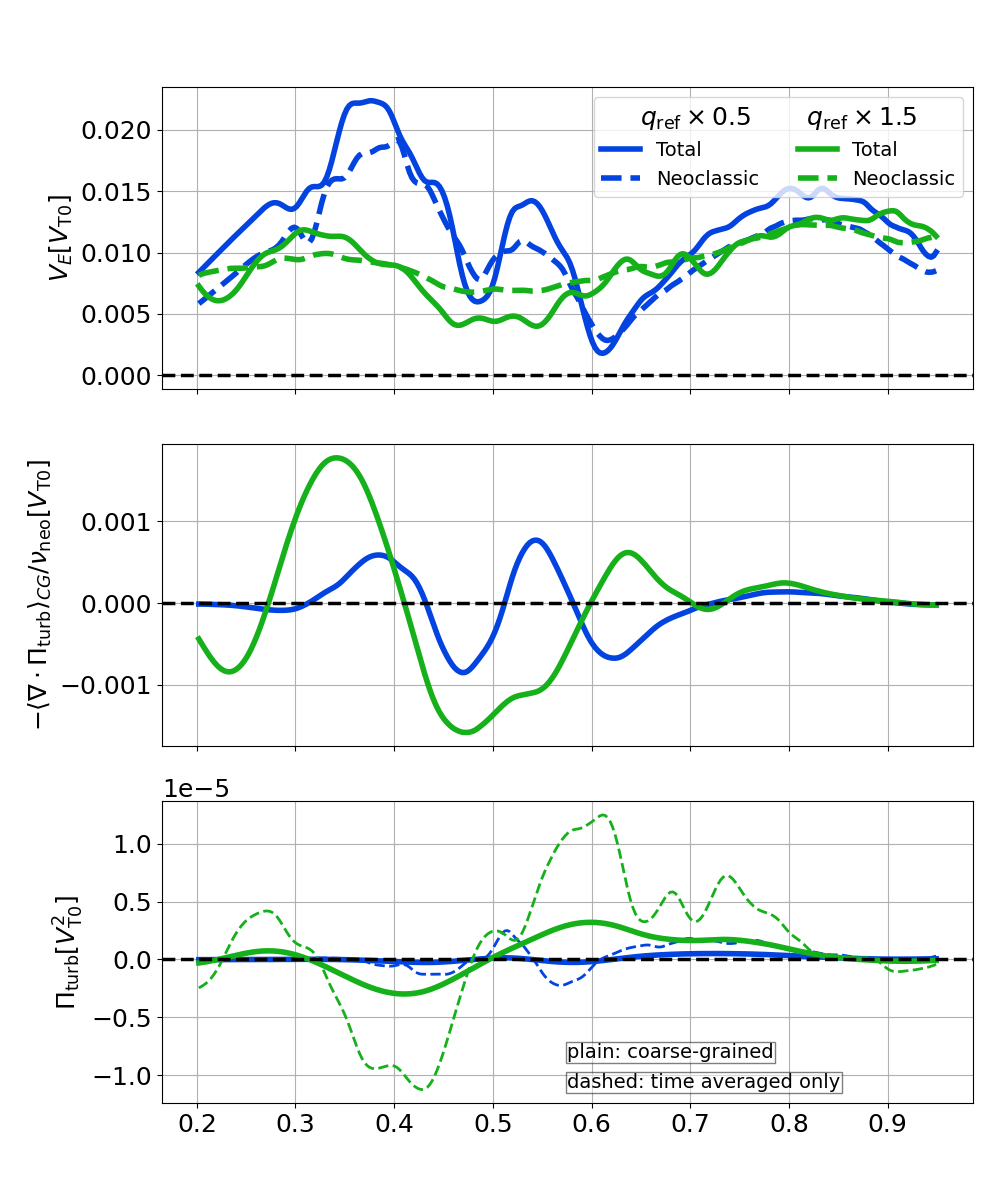

In [26]:
clear_output()
np.seterr(divide='ignore')

q_ar = [all_sim[0], all_sim[-1]]

fig = plt.figure(figsize=(10, 12))

ax_VE = fig.add_subplot(311)
ax_RS = fig.add_subplot(313)
ax_RS_nu = fig.add_subplot(312)

tmin = 200e3; tmax = 300e3
rhomin = 0.2; rhomax = 0.95

N = 30

for iq,q in enumerate(q_ar):
    # tmax = q['time'][-1]
    # tmin = tmax-5000

    itmin, itmax     = np.searchsorted(q['time'],[tmin,tmax])
    irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])

    rho     = q['rho'][irhomin:irhomax]
    VE      = np.mean(q['m_Er'][itmin:itmax,irhomin:irhomax],axis=0)
    RS      = 3*np.mean(q['RSpol'][itmin:itmax,irhomin:irhomax],axis=0) #+ np.mean(q['RSdia'][:,irhomin:irhomax],axis=0) 
    RS_CG      = np.mean(uniform_filter1d(uniform_filter1d(q['RSpol'],size=N,axis=1),size=N,axis=1)[itmin:itmax,irhomin:irhomax],axis=0)   
    divRS   = np.mean(uniform_filter1d(uniform_filter1d(q['drRSpol'] ,size=N,axis=1),size=N,axis=1)[itmin:itmax,irhomin:irhomax],axis=0)   
    nutheta = np.mean(q['nuneo_Gianakon'][itmin:itmax,irhomin:irhomax],axis=0)

    VE_neo = -np.mean( (0.7 * q['drT'] + (q['T']/q['n']) * q['drn'] + (q['eps']/q['q'])*q['VT'])[itmin:itmax,irhomin:irhomax],axis=0)

    q_on_eps_sq = (q['q']/q['eps'])[irhomin:irhomax]**2

    ax_VE.plot(rho, VE    ,c=q['c'],ls=q['ls'],label='Total',lw=4)
    ax_VE.plot(rho, VE_neo    ,c=q['c'],ls='--',label='Neoclassic',lw=4)
    ax_RS.plot(rho, RS ,c=q['c'],label=q['title_fancy'],lw=2,ls='--')
    ax_RS.plot(rho, RS_CG ,c=q['c'],ls=q['ls'],label=q['title_fancy'],lw=4)
    ax_RS_nu.plot(rho, -divRS/nutheta,c=q['c'],ls=q['ls'],label=q['title_fancy'],lw=4)
    #ax_RS_nu.plot(rho, VE-VE_neo,c=q['c'],ls='--',label=q['title_fancy'],lw=4)

# qprof_05_n0     = load_qprof_dict('data/TS45511_q05_n0.hdf5'    , r'$q_{ref} \times 0.5$ - $n=0$'         , c1='xkcd:blue')
# qprof_15_n0     = load_qprof_dict('data/TS45511_q15_n0.hdf5'    , r'$q_{ref} \times 1.5$ - $n=0$'         , c1='xkcd:red')

# VE_05_n0        = np.mean(qprof_05_n0['drT'][-10:-1,irhomin:irhomax],axis=0)
# VE_15_n0        = np.mean(qprof_15_n0['drT'][-10:-1,irhomin:irhomax],axis=0)
# ax_VE.plot(rho, VE_05_n0  ,c=qprof_05_n0['c'],ls=qprof_05_n0['ls'],label=qprof_05_n0['title_fancy'],lw=4)
# ax_VE.plot(rho, VE_15_n0  ,c=qprof_15_n0['c'],ls=qprof_15_n0['ls'],label=qprof_15_n0['title_fancy'],lw=4)


for axes in [ax_VE,ax_RS,ax_RS_nu]: 
    axes.axhline(y=0,c='k',ls='--')

# Remove xlabel and xticks from top plot
ax_VE.set_xlabel('')
ax_VE.set_xticklabels([])
ax_VE.set_ylabel(r'$V_E [V_{\rm T0}]$')
ax_VE.legend(ncol=2)

ax_RS.set_ylabel(r'$\Pi_{\rm turb} [V_{\rm T0}^2]$')
## add text to plot with bbox
ax_RS.text(0.5, 0.2, r'plain: coarse-grained', transform=ax_RS.transAxes, fontsize=14,verticalalignment='top',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})
ax_RS.text(0.5, 0.1, r'dashed: time averaged only', transform=ax_RS.transAxes, fontsize=14,verticalalignment='top',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

ax_RS_nu.set_xlabel(r'$r/a$')
ax_RS_nu.set_ylabel(r'$- \langle \nabla \cdot \Pi_{\rm turb} \rangle_{CG} / \nu_{\rm neo} [V_{\rm T0}]$')
ax_RS_nu.set_xlabel('')
ax_RS_nu.set_xticklabels([])

## set y ticks in scientific notation
ax_RS_nu.ticklabel_format(style='sci', axis='y', scilimits=(-4,4))

# set hspace to 0
plt.subplots_adjust(hspace=0)

ax_VE.legend(title=r'$q_{\rm ref} \times 0.5$       $q_{\rm ref} \times 1.5$',ncol=2,fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/rprof_VE_divRS_on_nuneo_RS_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='green'>**Papier**</font> - Profil radial de $V_E$ (total et néoclassique)

602600.0
192000.0
379800.0
379800.0
329800.0


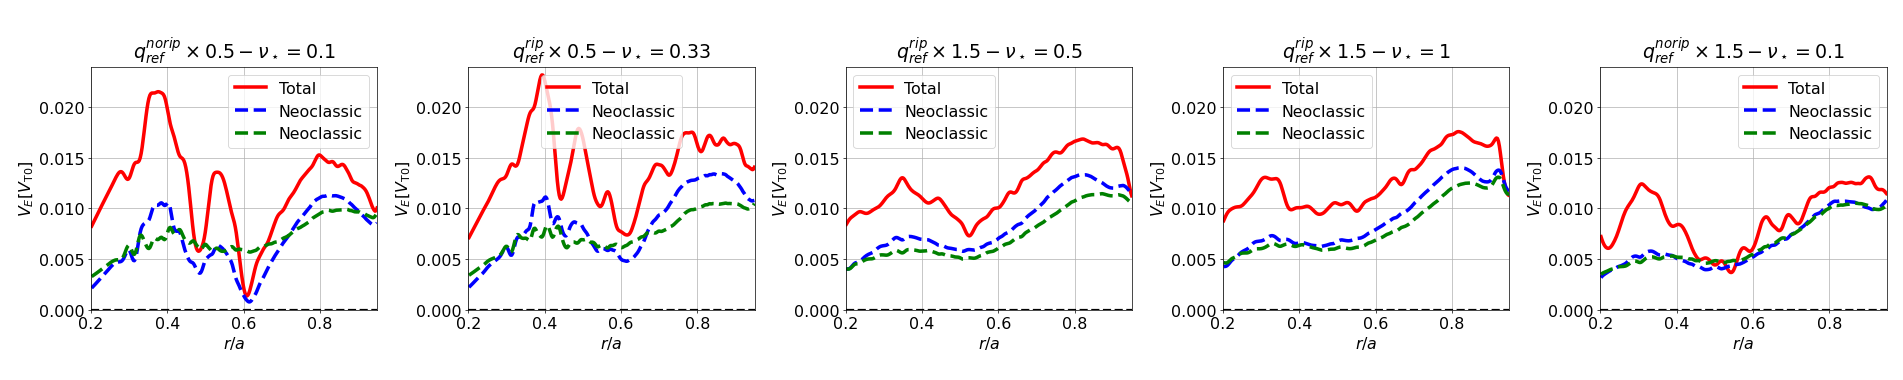

In [25]:
clear_output()
np.seterr(divide='ignore')

#q_ar = [all_sim[0], all_sim[-1]]
q_ar = all_sim

fig = plt.figure(figsize=(6*len(q_ar), 6))

tmin = 150e3; tmax = 300e3
rhomin = 0.2; rhomax = 0.95

for iq,q in enumerate(q_ar):

    ax_VE = fig.add_subplot(1,len(q_ar),1+iq)

    itmin, itmax     = np.searchsorted(q['time'],[tmin,tmax])
    irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])

    rho     = q['rho'][irhomin:irhomax]
    VE      = np.mean(q['m_Er'][itmin:itmax,irhomin:irhomax],axis=0)

    Kneo = q['Kneo_Kim_all'] ## Kneo with finite aspect ratio corrections
    VE_neo = -np.mean( ( (1-Kneo) * q['drT'] + (q['T']/q['n']) * q['drn'] + (q['eps']/q['q'])*q['VT'])[itmin:itmax,irhomin:irhomax],axis=0)
    VE_neo_noVT = -np.mean( ( (1-Kneo) * q['drT'] + (q['T']/q['n']) * q['drn'])[itmin:itmax,irhomin:irhomax],axis=0)

    q_on_eps_sq = (q['q']/q['eps'])[irhomin:irhomax]**2

    ax_VE.plot(rho, VE    ,c='r',ls=q['ls'],label='Total',lw=4)
    ax_VE.plot(rho, VE_neo    ,c='b',ls='--',label='Neoclassic',lw=4)
    ax_VE.plot(rho, VE_neo_noVT    ,c='g',ls='--',label='Neoclassic',lw=4)

    ax_VE.axhline(y=0,c='k',ls='--')

    print(q['time'][-1])

    # Remove xlabel and xticks from top plot
    ax_VE.set_ylabel(r'$V_E [V_{\rm T0}]$')
    ax_VE.legend()
    ax_VE.set_ylim(0,0.024)
    ax_VE.set_xlim(0.2,0.95)
    ax_VE.set_xlabel(r'$r/a$')
    ax_VE.set_title(q['title_fancy'])

fig.set_dpi(dpi_custom)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/rprof_VE_scanq_total_and_neo.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Tenseur de Reynolds $\Pi$

In [ ]:
clear_output()

q_ar = all_sim

fig = plt.figure(figsize=(10, 6))

ax_RS = fig.add_subplot(111)


tmin = 100e3; tmax = 200e3
rhomin = 0.2; rhomax = 0.9

N = 40

for iq,q in enumerate(q_ar):
    itmin, itmax     = np.searchsorted(q['time'],[tmin,tmax])
    irhomin, irhomax = np.searchsorted(q['rho'],[rhomin,rhomax])

    rho     = q['rho'][irhomin:irhomax]
    VE      = np.mean(q['m_Er'][itmin:itmax,irhomin:irhomax],axis=0)
    RS      = np.mean(q['RSpol'][itmin:itmax,irhomin:irhomax],axis=0)   
    RS_CG      = np.mean(uniform_filter1d(uniform_filter1d(q['RSpol'],size=N,axis=1),size=N,axis=1)[itmin:itmax,irhomin:irhomax],axis=0)   
    divRS   = np.mean(uniform_filter1d(uniform_filter1d(q['drRSpol'],size=N,axis=1),size=N,axis=1)[itmin:itmax,irhomin:irhomax],axis=0)   
    nutheta = np.mean(q['nutheta_Gianakon'][itmin:itmax,irhomin:irhomax],axis=0) * (q['q']/q['eps'])[irhomin:irhomax]**2
    q_on_eps_sq = q['q'][irhomin:irhomax]**2


    ax_RS.plot(rho, RS ,c=q['c'],label=q['title_fancy'],lw=2,ls='--')
    ax_RS.plot(rho, RS_CG ,c=q['c'],ls=q['ls'],label=q['title_fancy'],lw=4)


ax_RS.axhline(y=0,c='k',ls='--')

ax_RS.set_ylabel(r'$\Pi_{\rm turb} [V_{\rm T0}^2]$')
## add text to plot with bbox
ax_RS.text(0.5, 0.2, r'plain: coarse-grained', transform=ax_RS.transAxes, fontsize=14,verticalalignment='top',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})
ax_RS.text(0.5, 0.1, r'dashed: time averaged only', transform=ax_RS.transAxes, fontsize=14,verticalalignment='top',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})

# set hspace to 0
plt.subplots_adjust(hspace=0)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/rprof_VE_divRS_on_nuneo_RS_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='royalblue'>**Résultat**</font> - Tenseur diamagnétique

In [ ]:
clear_output()

q05 = all_sim[0]
q15 = all_sim[-1]

# if qprof_05_alignedGC7, qprof_15_alignedGC7 in locals():

fig = plt.figure(figsize=(12, 10))

ax_RSdia = fig.add_subplot(121)
ax_RSvE  = fig.add_subplot(122)
rhomin = 0.2; rhomax = 1.1

def RA(x,N):
    return uniform_filter1d(uniform_filter1d(x,size=N,axis=1),size=N,axis=1)

N = 1

itmin_q05, itmax_q05     = np.searchsorted(q05['time'],[q05['3Dtime_init'],q05['3Dtime_end']])
itmin_q15, itmax_q15     = np.searchsorted(q15['time'],[q15['3Dtime_init'],q15['3Dtime_end']])
irhomin, irhomax         = np.searchsorted(q05['rho'],[rhomin,rhomax])

rho            = q['rho'][irhomin:irhomax]
print(q05['time'][-1])

RSdia05        = np.mean(RA(q05['RSdia_new'],N)[:,irhomin:irhomax],axis=0)
RSdia05_old    = np.mean(RA(q05['RSdia'],N)[:,irhomin:irhomax],axis=0)
RSelec05       = np.mean(RA(q05['RSpol_vE'],N)[itmin_q05:itmax_q05,irhomin:irhomax],axis=0)
RSelec3D05     = np.mean(RA(q05['RSpol_vE_from3D_new'],N)[:,irhomin:irhomax],axis=0)
RSelec3D05_old = np.mean(RA(q05['RSpol_vE_from3D'],N)[:,irhomin:irhomax],axis=0)

RSdia15        = np.mean(RA(q15['RSdia_new'],N)[:,irhomin:irhomax],axis=0)
RSdia15_old    = np.mean(RA(q15['RSdia'],N)[:,irhomin:irhomax],axis=0)
RSelec15       = np.mean(RA(q15['RSpol_vE'],N)[itmin_q15:itmax_q15,irhomin:irhomax],axis=0)
RSelec3D15     = np.mean(RA(q15['RSpol_vE_from3D_new'],N)[:,irhomin:irhomax],axis=0)
RSelec3D15_old = np.mean(RA(q15['RSpol_vE_from3D'],N)[:,irhomin:irhomax],axis=0)

ax_RSdia.set_title(r'$\Pi_{\rm dia}$')
ax_RSdia.plot(rho, RSdia05    ,c='b',lw=4,         label=q05['title_fancy'])
ax_RSdia.plot(rho, RSdia15    ,c='r',lw=4   ,      label=q15['title_fancy'])

ax_RSvE.set_title(r'$\Pi_{\rm vE}$')
ax_RSvE.plot(rho, RSelec3D05    ,c='b',lw=4   ,      label=q05['title_fancy'])
ax_RSvE.plot(rho, RSelec3D15  ,c='r',lw=4   ,      label=q15['title_fancy'])


for axes in [ax_RSdia,ax_RSvE]: 
    axes.axhline(y=0,c='k',ls='--')
    axes.legend()
    axes.set_ylim(-7e-6, 7e-6)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.savefig('Figures/rprof_VE_divRS_on_nuneo_RS_scanq.pdf', format='pdf', bbox_inches='tight')

## <font color='green'>**Papier**</font> - Validation hypothèse $J_{turb} = - \nabla \cdot \Pi_{turb}$ 

In [53]:
clear_output()

plt.rcParams.update({'font.size': 20})

# q_ar = all_sim
q_ar = [all_sim[0],all_sim[-1]]

fig = plt.figure(figsize=(14,6))

for iq,q in enumerate(q_ar):
    
    ax  = fig.add_subplot(1,len(q_ar),1+iq)
    ax.set_title(q['title_fancy'])

    irhomin, irhomax = np.searchsorted(q['rho'],[0.4,1.0])
    rho = q['rho'][irhomin:irhomax]

    itdiag = -18

    Jturb = ( q['Jr_vE'] - q['Jr_vEn0'] )[itdiag,irhomin:irhomax]

    if 'RSdia' in q.keys():
        divPiturb =  q['drRSpol'][itdiag,irhomin:irhomax] + q['drRSdia'][itdiag,irhomin:irhomax] #la densité est inclue dans le calcul en moment du tenseur de Reynolds
        ax.plot(rho,-divPiturb,label=r'$- \frac{mn}{B_0} \nabla \cdot (\Pi_{E \times B} + \Pi_{\rm dia})$',c='r',lw=5)
    
    ax.plot(rho,Jturb,label=r'$(J_{Er} - J_{Er, n=0})$',c='b')

    if 0:
        divPiturb_approx =  q['drRSpol'][itdiag,irhomin:irhomax] * 4
        ax.plot(rho,-divPiturb_approx,label=r'$-3 \nabla \cdot (\Pi_{E \times B})$',c='g',ls='--')
    
    if iq==0:
        ax.legend()
    #     ax.text(0.05, 0.05, r'$t[\omega_{c0}^{-1}] = %.0f$' % q['time'][itdiag], transform=ax.transAxes, fontsize=14,
    #     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)) 

    for axes in fig.axes:
        axes.set_xlabel(r'$r/a$')
        axes.axhline(y=0,c='k',ls='--')
        axes.axvline(x=1,c='k',ls='--')
    

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('Figures/rprof_Jturb_Piturb.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='royalblue'>**Temporaire**</font> - Fonction porte "smooth" [▲](#sommaire)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smoothed_rectangular(x, left, right, k=10):
    """
    Returns a smoothed rectangular function with smoothed discontinuities.
    
    Parameters:
        x (array-like): The independent variable.
        left (float): The left edge of the rectangular function.
        right (float): The right edge of the rectangular function.
        k (float): Controls the steepness of the sigmoid function. Higher k leads to sharper transition.
        
    Returns:
        y (array-like): The smoothed rectangular function evaluated at x.
    """
    y = 1 / (1 + np.exp(-k * (x - left))) - 1 / (1 + np.exp(-k * (x - right)))
    return y

# Example usage
x = np.linspace(-10, 10, 1000)
y = smoothed_rectangular(x, -8, 8, k=5)
plt.figure()
plt.plot(x, y)
plt.show()